# Исследование HR-аналитики для компании «Работа с заботой»

HR-аналитики компании «Работа с заботой», помогающие бизнесу оптимизировать управление персоналом (предлагают, как избежать финансовых потерь и оттока сотрудников), хотят использовать машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Бизнесу важна удовлетворенность сотрудников работой, т.к. это напрямую влияет на отток сотрудников. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.


Компания предоставила данные с характеристиками сотрудников компании. Среди них - уровень удовлетверенности сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетверенности от 0 до 1, где 0 - совершенно неудовлетверен, 1 - полностью удовлетрен.

**Цели исследования:**
* Построение модели, которая сможет предсказать уровень удовлетворенности сотрудника
* Построение модели, которая сможет предсказать увольнение сотрудника из компании

**Ход исследования**

Данные для исследования будут получены из нескольких файлов. О качестве данных ничего не известно, поэтому перед тем, как приступать к целям исследования, понадобится обзор данных. Необходимо будет проверить данные на ошибки и оценить их влияние на исследование. На этапе предобработки нужно осуществить поиск возможностей исправления всех ошибок данных, которые не приведут к искажению конечного результата. При необходимости, осуществим создание новых столбцов.

**Этапы исследования:**
1. Загрузка и обзор данных
2. Предобработка данных
3. Исследовательский анализ
4. Подготовка данных
5. Обучение моделей
6. Написание общего вывода

## Предсказание уровня удовлетворенности сотрудника

### Загрузка данных

Установим и импортируем необходимые для исследования библиотеки:

In [1]:
!pip install phik -q
!pip install scikit-learn==1.6 -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    PolynomialFeatures,
    LabelEncoder
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor, DummyClassifier

Откроем файлы с датасетом:

In [3]:
try:
    train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', sep=',', decimal='.')
except:
    train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv', sep=',', decimal='.')

In [4]:
try:
    test_features = pd.read_csv('/datasets/test_features.csv', sep=',', decimal='.')
except:
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', sep=',', decimal='.')

In [5]:
try:
    test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', sep=',', decimal='.')
except:
    test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv', sep=',', decimal='.')

In [6]:
dataframes_1 = {
    'train_job_satisfaction_rate': train_job_satisfaction_rate,
    'test_features': test_features,
    'test_target_job_satisfaction_rate': test_target_job_satisfaction_rate
}

Выведем первые строки и общую информацию о датасете `train_job_satisfaction_rate`:

In [7]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Таблица представляет собой тренировочную выборку.

In [8]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Выведем первые строки и общую информацию о датасете `test_features`:

In [9]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Таблица представляет собой входные признаки тестовой выборки.

In [10]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Выведем первые строки и общую информацию о датасете `test_target_job_satisfaction_rate`:

In [11]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Таблица представляет собой целевой признак тестовой выборки.

In [12]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Таким образом, таблицы содержат следующие данные:
* `id` - уникальный идентификатор + сотрудника
* `dept` - отдел, в котором работает сотрудник
* `level` - уровень занимаемой должности
* `workload` - уровень загруженности сотрудника
* `employment_years` - длительность работы в компании (в годах)
* `last_year_promo` - показывает, было ли повышение за последний год
* `last_year_violations` - показывает, нарушал ли сотрудник трудовой договор за последний год
* `supervisor_evaluation` - оценка качества работы сотрудника, которую дал руководитель
* `salary` - ежемесячная зарплата сотрудника
* `job_satisfaction_rate` - уровень удовлетворенности сотрудника работой в компании, целевой признак

Данные в таблицах соответствуют описанию задач, заголовки приведены к нижнему регистру, типы данных в столбцах соответствуют формату данных.

### Предобработка данных

Проверим датафреймы на наличие пропусков в данных:

In [13]:
for name, df in dataframes_1.items():
    print(f'{name}:')
    print(f'{df.isna().sum()}\n')

train_job_satisfaction_rate:
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

test_features:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

test_target_job_satisfaction_rate:
id                       0
job_satisfaction_rate    0
dtype: int64



В датафреймах `train_job_satisfaction_rate` и `test_features` обнаружены пропуски данных в столбцах `dept` и `level`. Данные пропуски будут обработаны далее в пайплайне при обучении модели.

Далее проверим датафреймы на наличие явных дубликатов:

In [14]:
for name, df in dataframes_1.items():
    print(f'{name} - {df.duplicated().sum()}')

train_job_satisfaction_rate - 0
test_features - 0
test_target_job_satisfaction_rate - 0


В датафреймах не обнаружены явные дубликаты. Произведем проверку текстовых столбцов датафреймов на наличие неявных дубликатов:

In [15]:
# категориальные и количественные признаки
def get_columns(df):
    return {
        'cat_col_names': df.select_dtypes(exclude='number').columns.tolist(),
        'num_col_names': df.select_dtypes(include='number').columns.tolist()
    }

In [16]:
for name, df in dataframes_1.items():
    print(f'-------------------------------\n{name}:')
    for i in get_columns(df)['cat_col_names']:
        print(f'{i}: {df[i].unique().tolist()}')

-------------------------------
train_job_satisfaction_rate:
dept: ['sales', 'hr', 'technology', 'purchasing', 'marketing', nan]
level: ['junior', 'middle', 'sinior', nan]
workload: ['medium', 'high', 'low']
last_year_promo: ['no', 'yes']
last_year_violations: ['no', 'yes']
-------------------------------
test_features:
dept: ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' ']
level: ['junior', 'middle', 'sinior', nan]
workload: ['medium', 'low', 'high', ' ']
last_year_promo: ['no', 'yes']
last_year_violations: ['no', 'yes']
-------------------------------
test_target_job_satisfaction_rate:


Неявных дубликатов не обнаружено, но в датафреймах `train_job_satisfaction_rate` и `test_features` в столбце `level` имеется орфографическая ошибка в наименовании уровня занимаемой должности - исправим ее:

In [17]:
train_job_satisfaction_rate['level'] = train_job_satisfaction_rate['level'].replace('sinior', 'senior')
test_features['level'] = test_features['level'].replace('sinior', 'senior')

Также в датафрейме `test_features` в столбцах `dept` и `workload` в качестве значений указаны пробелы - заменим их на пропуски:

In [18]:
test_features.loc[test_features['dept'] == ' ', 'dept'] = np.nan
test_features.loc[test_features['workload'] == ' ', 'workload'] = np.nan

Проверим замену пробелов на пропуски:

In [19]:
for i in ['dept', 'workload']:
    print(f'{i}: {test_features[i].unique().tolist()}')

dept: ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan]
workload: ['medium', 'low', 'high', nan]


Полученные пропуски также будут обработаны далее в пайплайне при обучении модели.

### Исследовательский анализ данных

Для отображения количественных признаков из датафреймов в виде гистограмм и диаграмм размаха ("ящик с усами") определим функцию:

In [20]:
def show_graph_1(df_col, hist_title, hist_xlabel, boxplot_title):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1).grid(True)
    plt.hist(df_col, bins=30)
    plt.ylabel('Частота')
    plt.xlabel(hist_xlabel)
    plt.title(hist_title)
    plt.subplot(1, 2, 2).grid(True)
    plt.boxplot(df_col)
    plt.ylabel(hist_xlabel)
    plt.title(boxplot_title)
    plt.show()

Для отображения качественных признаков из датафреймов в виде столбчатых и круговых диаграмм определим функцию:

In [21]:
def show_graph_2(df_col, bar_title, bar_xlabel, pie_title, ascending=True):
    counts = df_col.value_counts(ascending=ascending)
    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    counts.plot(kind='bar', title=bar_title, grid=True, xlabel=bar_xlabel, ylabel='Количество')
    plt.subplot(1, 2, 2)
    counts.plot(kind='pie', ylabel='', title=pie_title, autopct='%1.1f%%')
    plt.show()

#### Количественные признаки

Определим количественные признаки датафрейма `train_job_satisfaction_rate` (тренировочная выборка):

In [22]:
get_columns(train_job_satisfaction_rate)['num_col_names']

['id',
 'employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

Определим количественные признаки датафрейма `test_features` (тестовая выборка):

In [23]:
get_columns(test_features)['num_col_names']

['id', 'employment_years', 'supervisor_evaluation', 'salary']

Количественные признаки датафреймов совпадают, т.к. для таблицы `test_features` количественным признаком также будет датафрейм `test_target_job_satisfaction_rate`.

Проведем исследовательский анализ количественных данных датафреймов `train_job_satisfaction_rate` и `test_features`. Выведем характеристики, дающие представление о выборках (числовое описание данных):

In [24]:
train_job_satisfaction_rate.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


In [25]:
test_features.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0


Отобразим столбчатую диаграмму для столбца `employment_years`:

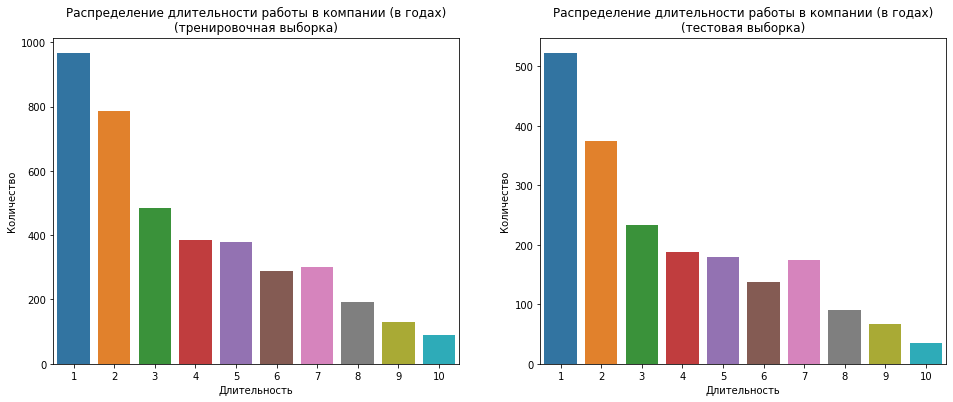

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
barplot_1 = sns.countplot(data=train_job_satisfaction_rate, x='employment_years', ax=axes[0])
barplot_1.axes.set_title('Распределение длительности работы в компании (в годах)\n(тренировочная выборка)')
barplot_1.set_xlabel('Длительность')
barplot_1.set_ylabel('Количество')
barplot_2 = sns.countplot(data=test_features, x='employment_years', ax=axes[1])
barplot_2.axes.set_title('Распределение длительности работы в компании (в годах)\n(тестовая выборка)')
barplot_2.set_xlabel('Длительность')
barplot_2.set_ylabel('Количество');

Распределение длительности работы сотрудников в компании похоже на экспоненциальное. Большая часть работников работают в компании непродолжительное время (1-2 года).

Отобразим столбчатую диаграмму для столбца `supervisor_evaluation`:

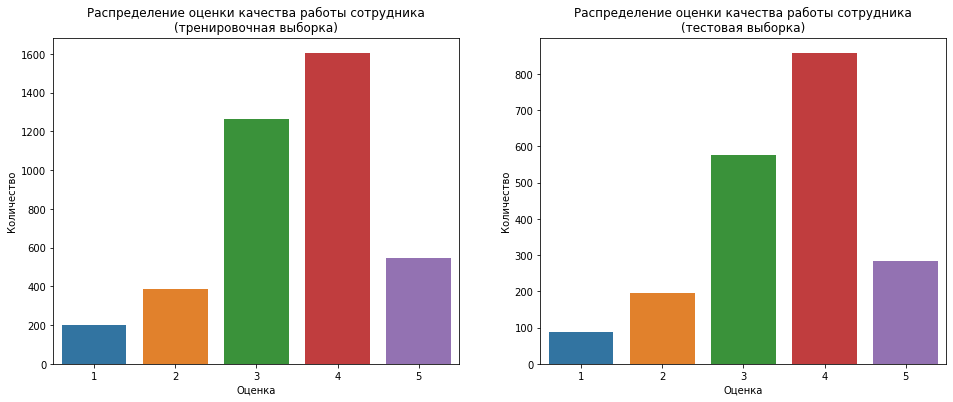

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
barplot_1 = sns.countplot(data=train_job_satisfaction_rate, x='supervisor_evaluation', ax=axes[0])
barplot_1.axes.set_title('Распределение оценки качества работы сотрудника\n(тренировочная выборка)')
barplot_1.set_xlabel('Оценка')
barplot_1.set_ylabel('Количество')
barplot_2 = sns.countplot(data=test_features, x='supervisor_evaluation', ax=axes[1])
barplot_2.axes.set_title('Распределение оценки качества работы сотрудника\n(тестовая выборка)')
barplot_2.set_xlabel('Оценка')
barplot_2.set_ylabel('Количество');

Распределение оценки качества работы сотрудника является асимметричным. В основном руководители дают положительную оценку качества работы сотрудника (3-4).

Отобразим гистограмму и "ящик с усами" для столбца `salary`:

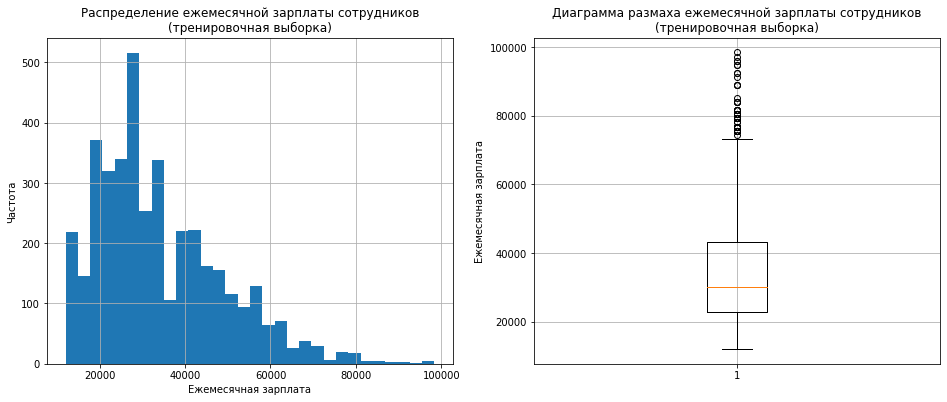

In [28]:
show_graph_1(
    train_job_satisfaction_rate['salary'],
    'Распределение ежемесячной зарплаты сотрудников\n(тренировочная выборка)',
    'Ежемесячная зарплата',
    'Диаграмма размаха ежемесячной зарплаты сотрудников\n(тренировочная выборка)'
)

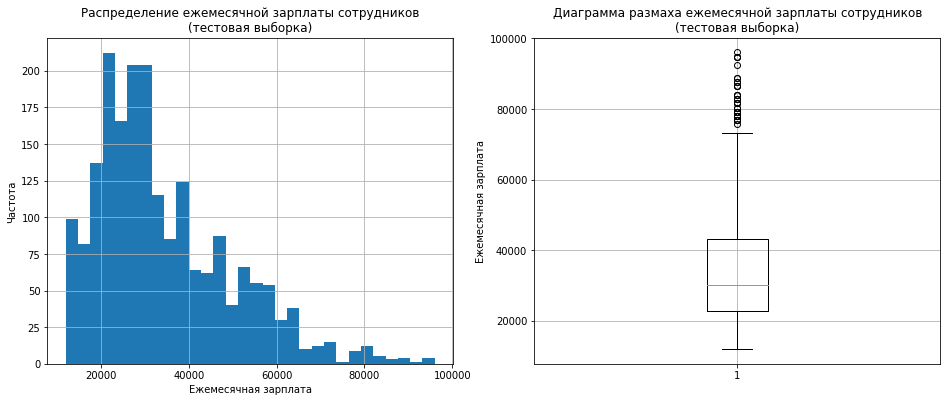

In [29]:
show_graph_1(
    test_features['salary'],
    'Распределение ежемесячной зарплаты сотрудников\n(тестовая выборка)',
    'Ежемесячная зарплата',
    'Диаграмма размаха ежемесячной зарплаты сотрудников\n(тестовая выборка)'
)

Распределение ежемесячной зарплаты сотрудников похоже на распределение Пуассона. Большая часть сотрудников получает зарплату 20000-30000. На графике видна малая часть работников с высокой заработной платой, видимо это руководство компании. Эти данные не считаются аномалиями, поэтому их не будем исключать из анализа.

Отобразим гистограмму и "ящик с усами" для столбца `job_satisfaction_rate`:

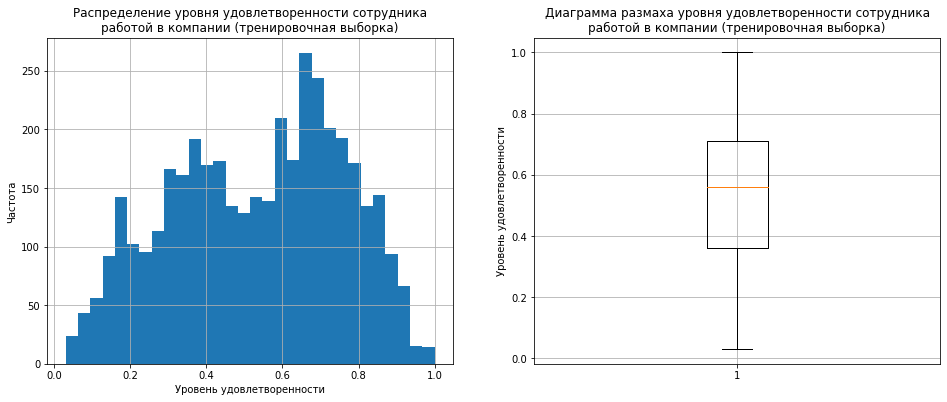

In [30]:
show_graph_1(
    train_job_satisfaction_rate['job_satisfaction_rate'],
    'Распределение уровня удовлетворенности сотрудника\nработой в компании (тренировочная выборка)',
    'Уровень удовлетворенности',
    'Диаграмма размаха уровня удовлетворенности сотрудника\nработой в компании (тренировочная выборка)'
)

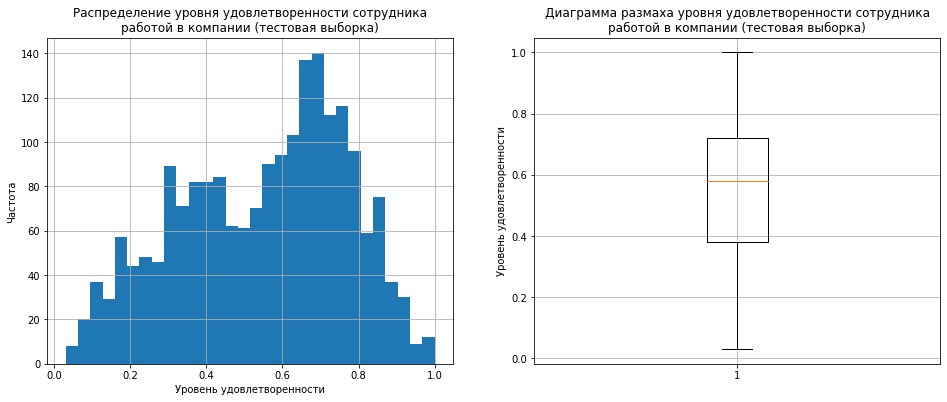

In [31]:
show_graph_1(
    test_target_job_satisfaction_rate['job_satisfaction_rate'],
    'Распределение уровня удовлетворенности сотрудника\nработой в компании (тестовая выборка)',
    'Уровень удовлетворенности',
    'Диаграмма размаха уровня удовлетворенности сотрудника\nработой в компании (тестовая выборка)'
)

Распределение уровня удовлетворенности сотрудника работой в компании близко к нормальному. Выбросов и аномальных значений нет.

#### Категориальные признаки

Определим категориальные признаки датафрейма `train_job_satisfaction_rate` (тренировочная выборка):

In [32]:
get_columns(train_job_satisfaction_rate)['cat_col_names']

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

Определим категориальные признаки датафрейма `test_features` (тестовая выборка):

In [33]:
get_columns(test_features)['cat_col_names']

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

Категориальные признаки датафреймов совпадают. Проведем исследовательский анализ категориальных данных датафреймов `train_job_satisfaction_rate` и `test_features`.

Отобразим столбчатую и круговую диаграммы для столбца `dept`:

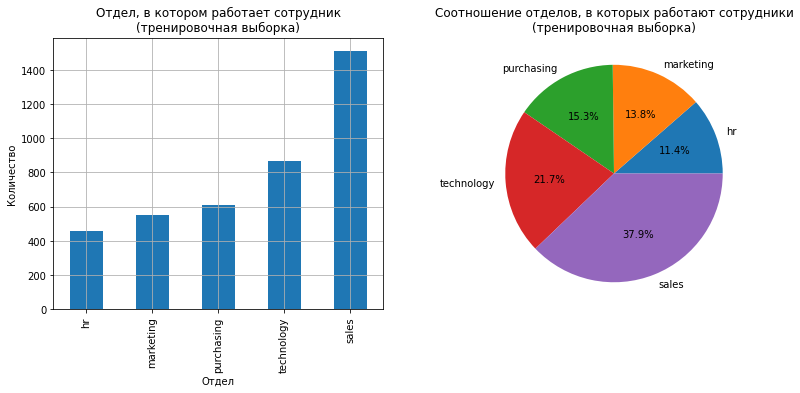

In [34]:
show_graph_2(
    train_job_satisfaction_rate['dept'],
    'Отдел, в котором работает сотрудник\n(тренировочная выборка)',
    'Отдел',
    'Соотношение отделов, в которых работают сотрудники\n(тренировочная выборка)'
)

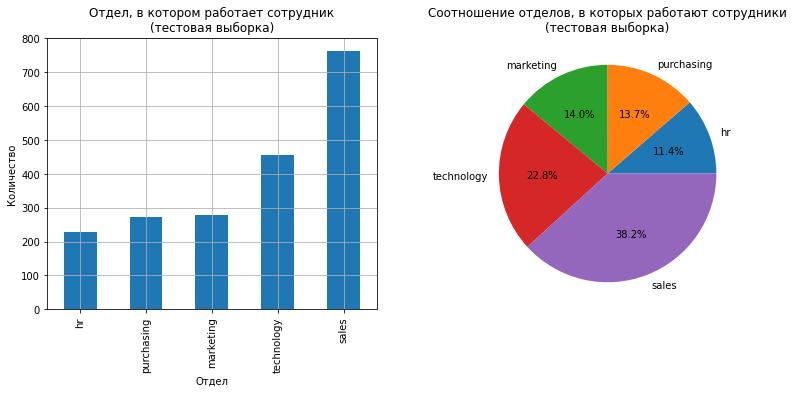

In [35]:
show_graph_2(
    test_features['dept'],
    'Отдел, в котором работает сотрудник\n(тестовая выборка)',
    'Отдел',
    'Соотношение отделов, в которых работают сотрудники\n(тестовая выборка)'
)

Большинство сотрудников работают в продажах (38%), меньше всего работников - в управлении персоналом (11%).

Отобразим столбчатую и круговую диаграммы для столбца `level`:

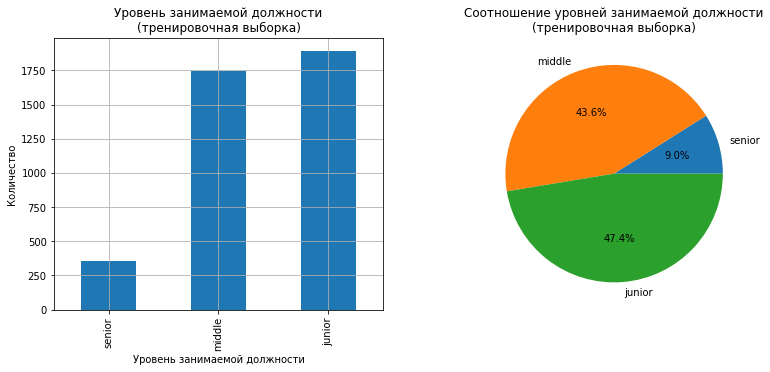

In [36]:
show_graph_2(
    train_job_satisfaction_rate['level'],
    'Уровень занимаемой должности\n(тренировочная выборка)',
    'Уровень занимаемой должности',
    'Соотношение уровней занимаемой должности\n(тренировочная выборка)'
)

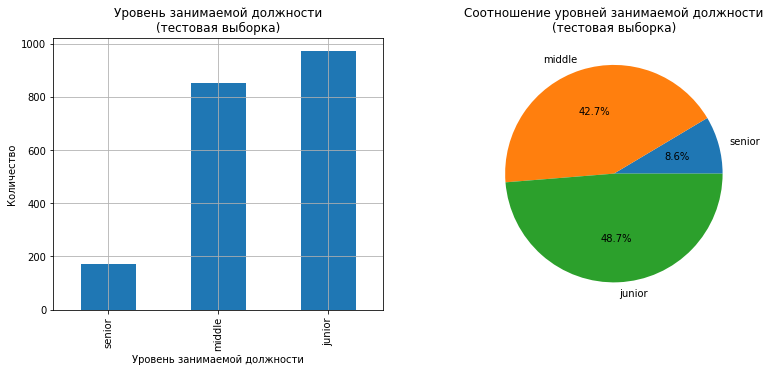

In [37]:
show_graph_2(
    test_features['level'],
    'Уровень занимаемой должности\n(тестовая выборка)',
    'Уровень занимаемой должности',
    'Соотношение уровней занимаемой должности\n(тестовая выборка)'
)

В компании больше всего работников уровней junior (47-49%) и middle (43-44%).

Отобразим столбчатую и круговую диаграммы для столбца `workload`:

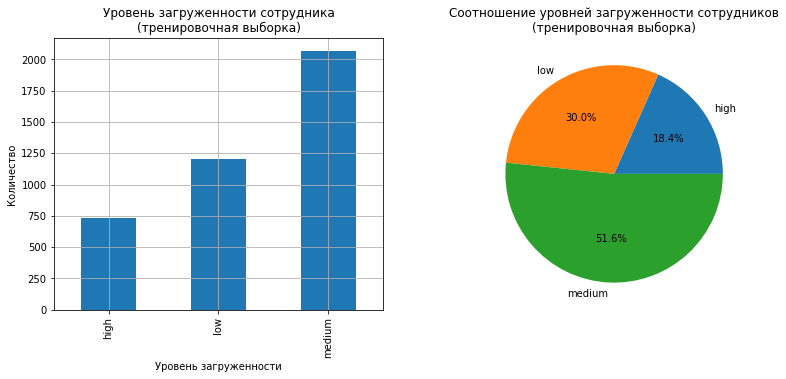

In [38]:
show_graph_2(
    train_job_satisfaction_rate['workload'],
    'Уровень загруженности сотрудника\n(тренировочная выборка)',
    'Уровень загруженности',
    'Соотношение уровней загруженности сотрудников\n(тренировочная выборка)'
)

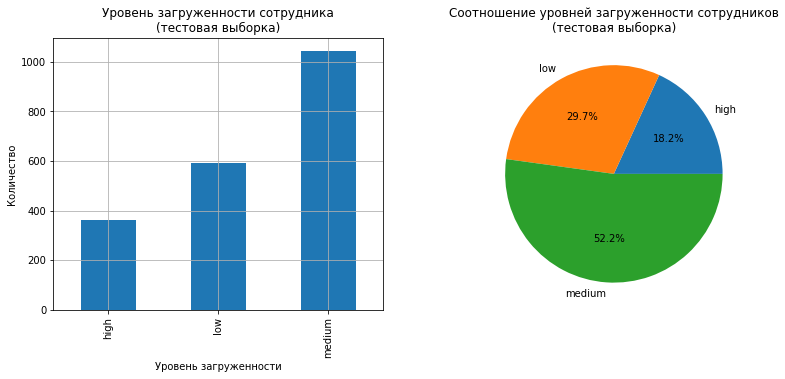

In [39]:
show_graph_2(
    test_features['workload'],
    'Уровень загруженности сотрудника\n(тестовая выборка)',
    'Уровень загруженности',
    'Соотношение уровней загруженности сотрудников\n(тестовая выборка)'
)

52% сотрудников имеют среднюю загрузку, высокую загрузку имеют 18% работников.

Отобразим столбчатую и круговую диаграммы для столбца `last_year_promo`:

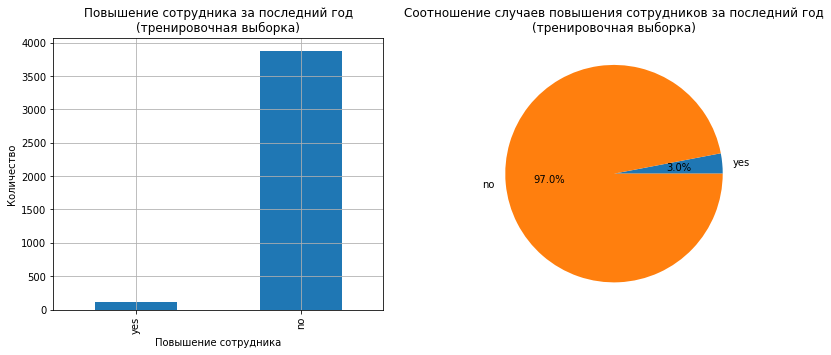

In [40]:
show_graph_2(
    train_job_satisfaction_rate['last_year_promo'],
    'Повышение сотрудника за последний год\n(тренировочная выборка)',
    'Повышение сотрудника',
    'Соотношение случаев повышения сотрудников за последний год\n(тренировочная выборка)'
)

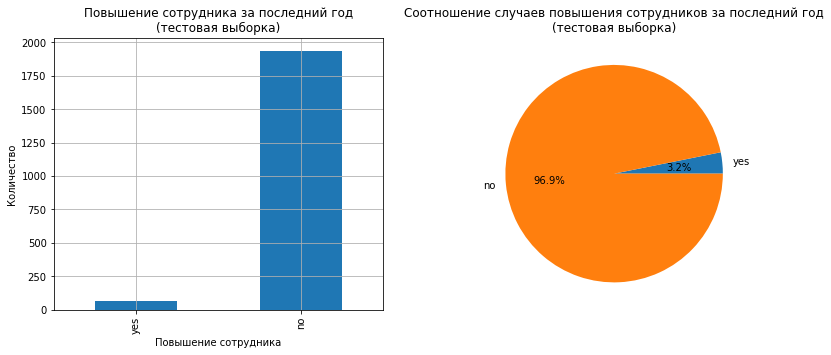

In [41]:
show_graph_2(
    test_features['last_year_promo'],
    'Повышение сотрудника за последний год\n(тестовая выборка)',
    'Повышение сотрудника',
    'Соотношение случаев повышения сотрудников за последний год\n(тестовая выборка)'
)

Подавляющее большинство сотрудников (97%) не имело повышения за последний год.

Отобразим столбчатую и круговую диаграммы для столбца `last_year_violations`:

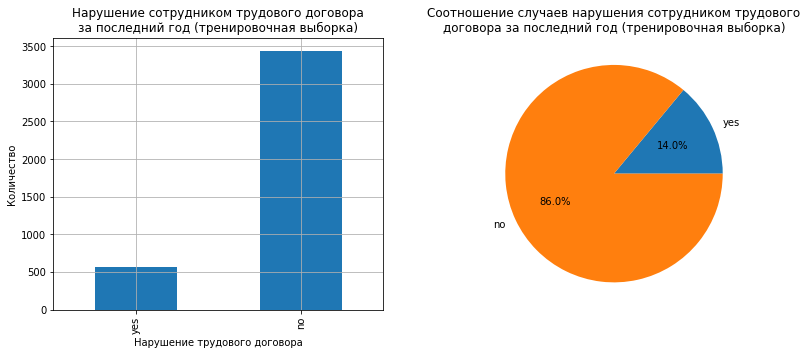

In [42]:
show_graph_2(
    train_job_satisfaction_rate['last_year_violations'],
    'Нарушение сотрудником трудового договора\nза последний год (тренировочная выборка)',
    'Нарушение трудового договора',
    'Соотношение случаев нарушения сотрудником трудового\nдоговора за последний год (тренировочная выборка)'
)

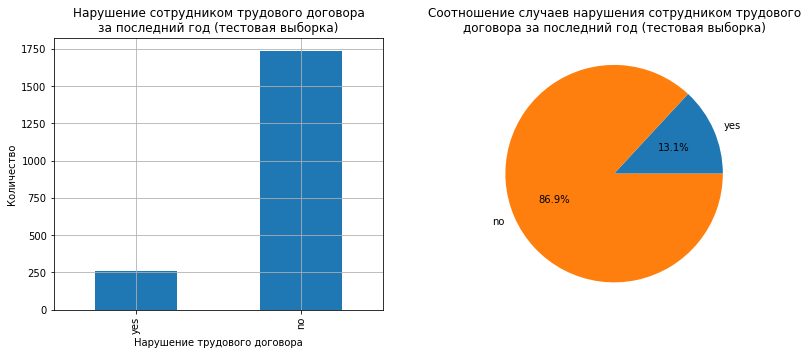

In [43]:
show_graph_2(
    test_features['last_year_violations'],
    'Нарушение сотрудником трудового договора\nза последний год (тестовая выборка)',
    'Нарушение трудового договора',
    'Соотношение случаев нарушения сотрудником трудового\nдоговора за последний год (тестовая выборка)'
)

Подавляющее большинство сотрудников (86-87%) не нарушало трудовой договор за последний год.

### Корреляционный анализ

Определим функцию для отображения тепловой карты корреляционной матрицы:

In [44]:
def get_cm_plot(df, interval_cols=get_columns(df)['num_col_names']):
    phik_matrix = df.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
    plot_correlation_matrix(phik_matrix.values,
                        x_labels=phik_matrix.columns,
                        y_labels=phik_matrix.index,
                        vmin=0,
                        vmax=1,
                        color_map='Reds',
                        title=r'Тепловая карта корреляционной матрицы $\phi_K$',
                        fontsize_factor=1.5,
                        figsize=(20, 15),
                        identity_layout=False
                       )

Проведем корреляционный анализ признаков в количественной шкале в датафрейме для моделирования `train_job_satisfaction_rate`. Рассчитаем коэффициенты корреляции между всеми количественными признаками и отобразим матрицу корреляций с помощью тепловой карты:

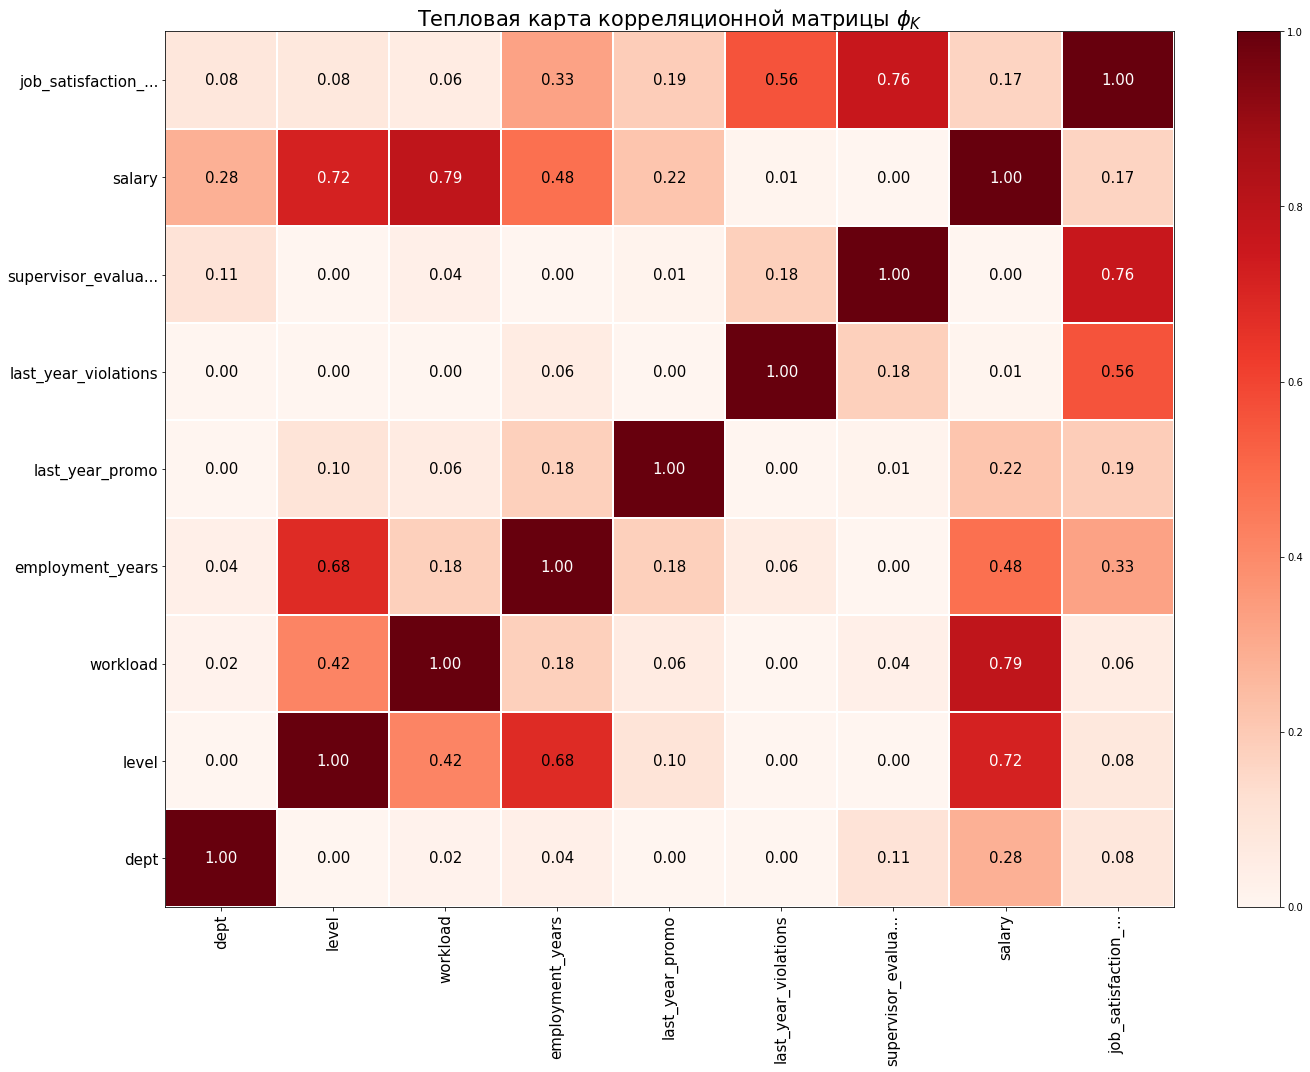

In [45]:
get_cm_plot(train_job_satisfaction_rate, ['id', 'salary', 'job_satisfaction_rate'])

Т.к. тренировочная и тестовая выборки нам предоставлены HR-аналитиками, то необходимо убедиться, что в данных нет существенных различий в части распределений признаков и что оценка модели, полученная на тестовой выборке, будет корректной. Поэтому также построим аналогичную матрицу корреляций и для тестовой выборки `test_features`:

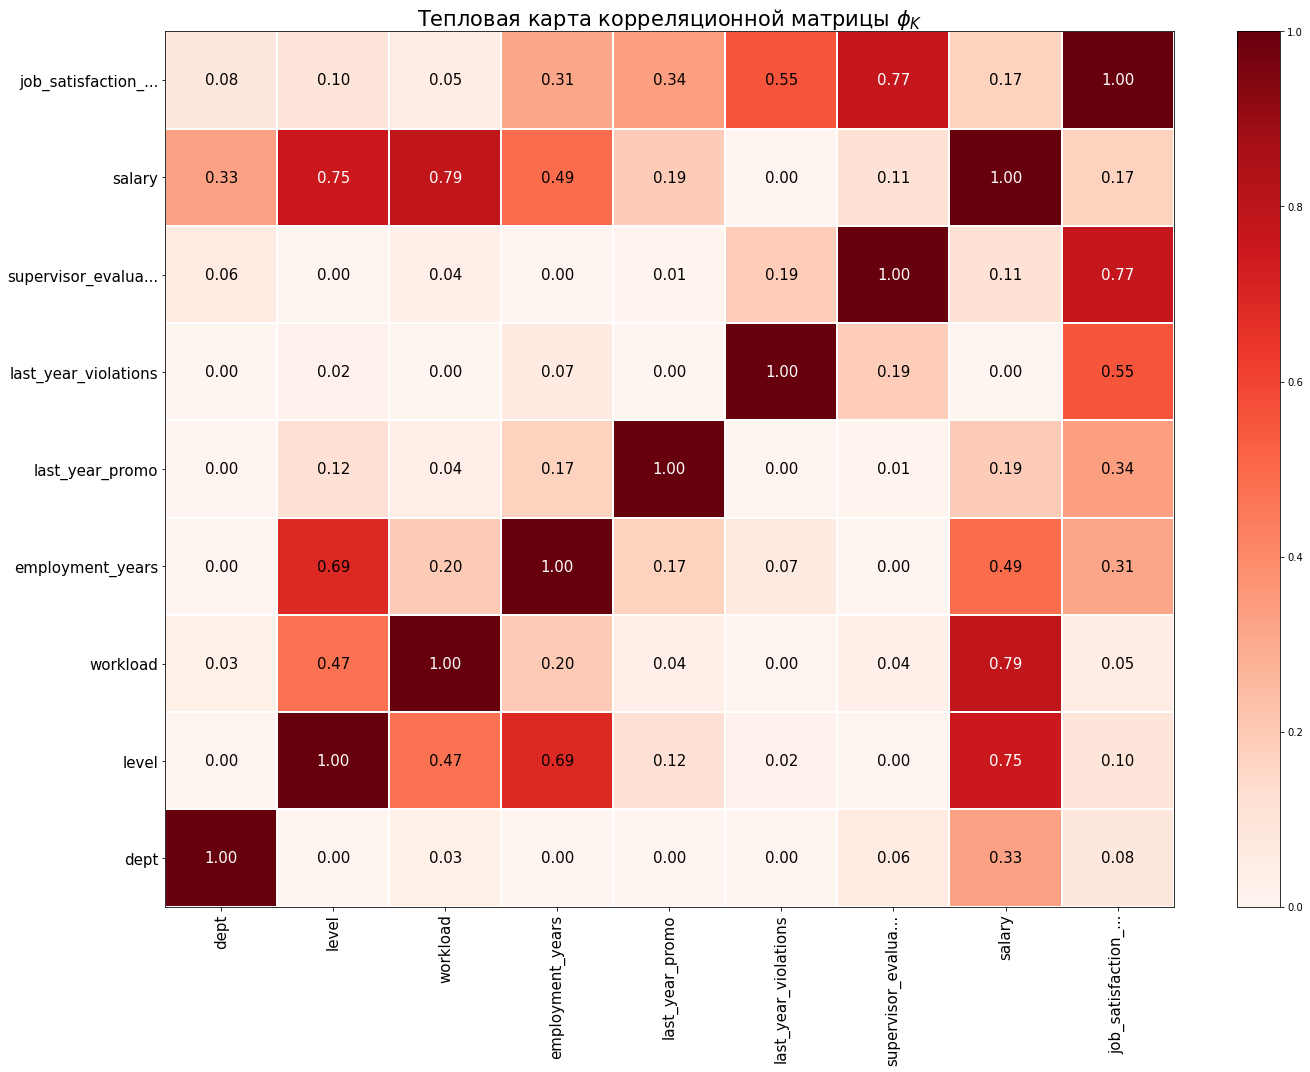

In [46]:
get_cm_plot(
    test_features.merge(test_target_job_satisfaction_rate, on='id', how='left'),
    ['id', 'salary', 'job_satisfaction_rate']
)

Темные тона тепловой карты говорят о сильной линейной зависимости, а светлые - о слабой. Судя по тепловой карте, самая сильная прямая связь с целевым признаком `job_satisfaction_rate` у входных признаков:
* `supervisor_evaluation` - оценка качества работы сотрудника, которую дал руководитель, сильно влияет на уровень удовлетворенности сотрудника работой в компании
* `last_year_violations` - нарушение или отсутствие за последний год нарушений сотрудником трудового договора также свидетельствует об удовлетворенности сотрудником работой в компании

При этом целевой признак `job_satisfaction_rate` слабо связан с признаками `workload`, `level` и `dept` (уровень загруженности, уровень занимаемой должности и отдел не влияют на уровень удовлетворенности сотрудника работой в компании).

Мультиколлинеарность между признаками не обнаружена. От признаков со слабой корреляцией с таргетом избавляться не будем, т.к. они могут быть важны при принятии решения модели.

### Моделирование с использованием пайплайнов

Используя пайплайны, применим следующие модели:
* Модель DecisionTreeRegressor (дерево решений)
* Модель LinearRegression (линейная регрессия)

Зададим константы:

In [47]:
RANDOM_STATE = 42

Разделим данные тренировочной выборки:

In [48]:
X_train = train_job_satisfaction_rate.drop(['id', 'job_satisfaction_rate'], axis=1)

In [49]:
y_train = train_job_satisfaction_rate['job_satisfaction_rate']
X_train.shape, y_train.shape

((4000, 8), (4000,))

Создадим списки с названиями признаков:

In [50]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

Создадим пайплайны для подготовки признаков:

In [51]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    #('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [52]:
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'senior'],
            ['low', 'medium', 'high']
        ],
        handle_unknown='use_encoded_value',
        unknown_value=np.nan)
    ),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [53]:
num_pipe = Pipeline([
    ('scaler', StandardScaler()),
    #('poly', PolynomialFeatures(2)),
    ('minmax', MinMaxScaler())
])

Создадим общий пайплайн для обработки данных:

In [54]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

Создадим итоговый пайплайн - подготовка данных и модель:

In [55]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

Создадим словарь со значениями гиперпараметров:

In [56]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 5),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Для оценки качества моделей напишем функцию, которая будет вычислять метрику SMAPE (симметричное среднее абсолютное процентное отклонение):

In [57]:
def smape(y_true, y_pred):
    #return (100 / len(y_true)) * np.sum(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred))/2))
    return np.mean(np.abs(y_true - y_pred) / ((np.abs(y_pred) + np.abs(y_true))/2)) * 100

Создадим пользовательскую метрику:

In [58]:
smape_scorer = make_scorer(smape, greater_is_better=False)

Для поиска лучшей модели будем использовать RandomizedSearchCV - наиболее быстрый и точный способ:

In [59]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и ее параметры:\n\n', randomized_search.best_estimator_)
print('Метрика SMAPE лучшей модели на кросс-валидации:', (-1) * randomized_search.best_score_)

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

На тренировочных данных лучше всех себя показала модель DecisionTreeRegressor со следующими параметрами (значение метрики SMAPE на кросс-валидации составило 17.15):
* max_depth=14
* max_features=2
* min_samples_split=5
* random_state=42

Проверим работу модели на тестовой выборке. Для этого объединим тестовые данные в один датафрейм (чтобы сопоставить данные по каждому пользователю) и посчитаем метрику SMAPE на тестовых данных:

In [60]:
test = test_features.merge(test_target_job_satisfaction_rate, on='id', how='left')
X_test = test.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test['job_satisfaction_rate']
print(f'Метрика SMAPE лучшей модели на тестовой выборке: {smape(y_test, randomized_search.best_estimator_.predict(X_test))}')

Метрика SMAPE лучшей модели на тестовой выборке: 14.83714069101538


Критерий успеха - значение метрики SMAPE на тестовой выборке меньше 15, получается, что модель работает успешно.

Важно также проверить лучшую модель на адекватность, сравнив качество ее предсказаний с качеством модели, которая предсказывала бы константу (чтобы вдруг не оказалось, что не было бы большого смысла заниматься созданием новых признаков, тюнингом и кросс-валидацией моделей, если можно было бы просто предсказывать среднее значение тренировочной выборки). В качестве константной модели будем использовать DummyRegressor - эта модель как раз создана для генерирования константных предсказаний:

In [61]:
param_grid_dummy = [
    # словарь для модели DummyRegressor()
    {
        'models': [DummyRegressor()],
        'models__strategy': ['mean', 'median', 'quantile', 'constant'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [129]:
randomized_search_dummy = RandomizedSearchCV(
    pipe_final, 
    param_grid_dummy, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_dummy.fit(X_train, y_train)

print('Лучшая модель и ее параметры:\n\n', randomized_search_dummy.best_estimator_)
print(f'Метрика SMAPE лучшей модели на тестовой выборке: {smape(y_test, randomized_search_dummy.best_estimator_.predict(X_test))}')

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/conda/lib/python3.

Результат тестирования нашей модели на тестовой выборке оказался лучше, чем результат константной модели - значит, наша модель не является бесполезной.

### Анализ важности признаков

Проведем оценку важности признаков для лучшей модели.

Лучшая модель:

In [63]:
best_model = randomized_search.best_estimator_.named_steps['models']

Данные, на которых модель обучалась:

In [64]:
preprocessor = randomized_search.best_estimator_['preprocessor']
X_train_preprocessor = preprocessor.transform(X_train)
features_names = (list(preprocessor['ohe'].get_feature_names_out()) +
                  list(preprocessor['ord'].get_feature_names_out()) +
                  list(preprocessor['num'].get_feature_names_out()))
X = pd.DataFrame(X_train_preprocessor, columns=features_names)
X.head()

,dept_marketing,dept_purchasing,dept_sales,dept_technology,last_year_promo_yes,last_year_violations_yes,level,workload,employment_years,supervisor_evaluation,salary
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.675991,-2.455174,-0.666273
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.675991,1.510381,0.300245
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.069351,-1.463785,-1.471705
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.110731,-1.463785,-1.068989
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.069351,-0.472397,-0.746816


Произведем оценку важности признаков модели DecisionTreeRegressor:

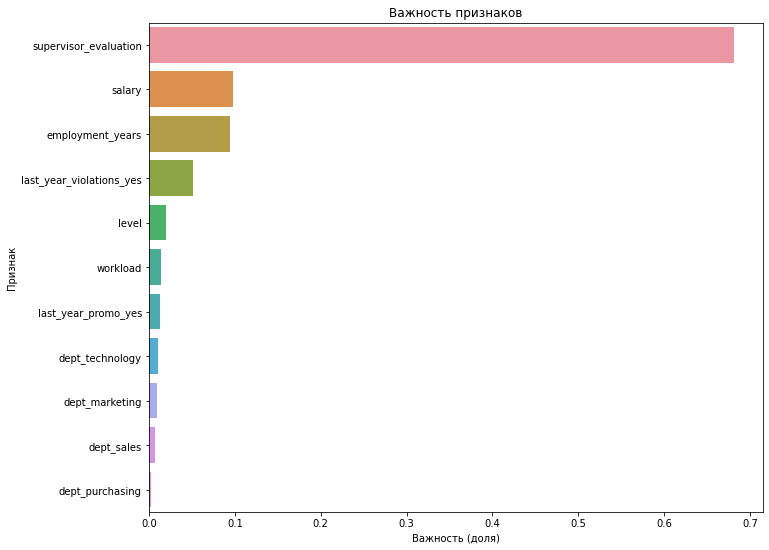

In [65]:
feature_importances = pd.DataFrame({'Признак': X.columns, 'Важность': best_model.feature_importances_}).sort_values('Важность', ascending=False)
plt.figure(figsize=(11, 9))
ax = sns.barplot(x='Важность', y='Признак', data=feature_importances)
ax.set_title('Важность признаков')
ax.set_xlabel('Важность (доля)')
ax.set_ylabel('Признак')
plt.show()

Самыми важными признаками в модели являются:
* `supervisor_evaluation` - оценка качества работы, данная руководителем сотруднику, имеет наибольшую важность в модели (подтверждение выводов, сделанных на этапе корреляционного анализа)
* `salary` - размер ежемесячной зарплаты влияет на удовлетворенность сотрудником работой
* `employment_years` - логично, что если работник длительное время работает в компании, то он удовлетворен своей работой

На уровень удовлетворенности сотрудника работой в компании мало влияет отдел, в котором сотрудник работает.

### Выводы

В данном разделе исследования была найдена и обучена лучшая модель по предсказанию уровня удовлетворенности сотрудника своей работой. Оценка качества модели проводилась по метрике SMAPE (симметричное среднее абсолютное процентное отклонение). Значение метрики на тестовой выборке составляет 14.84, лучшая модель - DecisionTreeRegressor с параметрами:
* max_depth=14
* max_features=2
* min_samples_split=5
* random_state=42

Данная модель справилась с задачей неплохо, т.к. деревья решений лучше объясняют нелинейные зависимости признаков, нежели линейная регрессия.

Самыми важными признаками в модели являются оценка качества работы сотрудника, его заработная плата и длительность работы в компании.

## Предсказание увольнения сотрудника

### Загрузка данных

Откроем файлы с датасетом:

In [66]:
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv', sep=',', decimal='.')
except:
    train_quit = pd.read_csv('https://code.s3.yandex.net/train_quit.csv', sep=',', decimal='.')

In [67]:
try:
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv', sep=',', decimal='.')
except:
    test_target_quit = pd.read_csv('https://code.s3.yandex.net/test_target_quit.csv', sep=',', decimal='.')

In [68]:
dataframes_2 = {
    'train_quit': train_quit,
    'test_target_quit': test_target_quit
}

Выведем первые строки и общую информацию о датасете `train_quit`:

In [69]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Таблица представляет собой тренировочную выборку.

In [70]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


В качестве таблицы, представляющей собой входные признаки тестовой выборки, будет выступать датафрейм `test_features`.

Выведем первые строки и общую информацию о датасете `test_target_quit`:

In [71]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Таблица представляет собой целевой признак тестовой выборки.

In [72]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Таким образом, таблицы имеют те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это `quit` - увольнение сотрудника из компании.

Данные в таблицах соответствуют описанию задач, заголовки приведены к нижнему регистру, типы данных в столбцах соответствуют формату данных.

### Предобработка данных

Проверим датафреймы на наличие пропусков в данных:

In [73]:
for name, df in dataframes_2.items():
    print(f'{name}:')
    print(f'{df.isna().sum()}\n')

train_quit:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

test_target_quit:
id      0
quit    0
dtype: int64



В датафреймах не обнаружены пропуски данных. Далее проверим датафреймы на наличие явных дубликатов:

In [74]:
for name, df in dataframes_2.items():
    print(f'{name} - {df.duplicated().sum()}')

train_quit - 0
test_target_quit - 0


В датафреймах не обнаружены явные дубликаты. Произведем проверку текстовых столбцов датафреймов на наличие неявных дубликатов:

In [75]:
for name, df in dataframes_2.items():
    print(f'-------------------------------\n{name}:')
    for i in get_columns(df)['cat_col_names']:
        print(f'{i}: {df[i].unique().tolist()}')

-------------------------------
train_quit:
dept: ['sales', 'purchasing', 'marketing', 'technology', 'hr']
level: ['middle', 'junior', 'sinior']
workload: ['high', 'medium', 'low']
last_year_promo: ['no', 'yes']
last_year_violations: ['no', 'yes']
quit: ['no', 'yes']
-------------------------------
test_target_quit:
quit: ['yes', 'no']


Неявных дубликатов не обнаружено, но в датафрейме `train_quit` в столбце `level` имеется орфографическая ошибка в наименовании уровня занимаемой должности - исправим ее:

In [76]:
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')

Проверим замену:

In [77]:
train_quit['level'].unique().tolist()

['middle', 'junior', 'senior']

Пропусков в данных нет, также как и явных и неявных дубликатов. Данные готовы для проведения исследовательского анализа.

### Исследовательский анализ данных

#### Количественные признаки

Определим количественные признаки датафрейма `train_quit` (тренировочная выборка):

In [78]:
get_columns(train_quit)['num_col_names']

['id', 'employment_years', 'supervisor_evaluation', 'salary']

Проведем исследовательский анализ количественных данных датафрейма `train_quit`. Выведем характеристики, дающие представление о выборке (числовое описание данных):

In [79]:
train_quit.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28375,260158.031387,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70150,2.541852,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.00,30000.0,43200.00,96000.0


Отобразим столбчатую диаграмму для столбца `employment_years`:

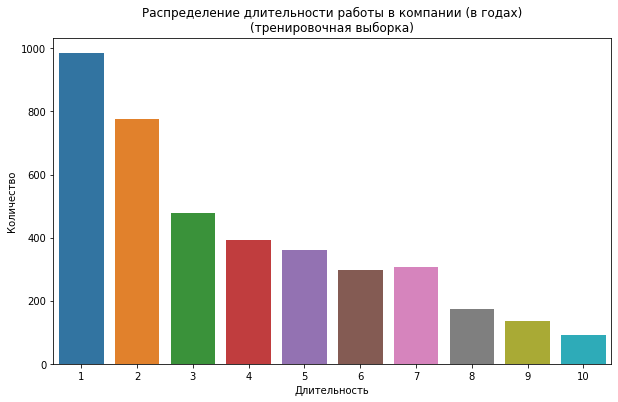

In [80]:
plt.figure(figsize=(10, 6))
barplot = sns.countplot(data=train_quit, x='employment_years')
barplot.axes.set_title('Распределение длительности работы в компании (в годах)\n(тренировочная выборка)')
barplot.set_xlabel('Длительность')
barplot.set_ylabel('Количество');

Распределение длительности работы сотрудников в компании похоже на экспоненциальное. Большая часть работников работают в компании непродолжительное время (1-2 года).

Отобразим столбчатую диаграмму для столбца `supervisor_evaluation`:

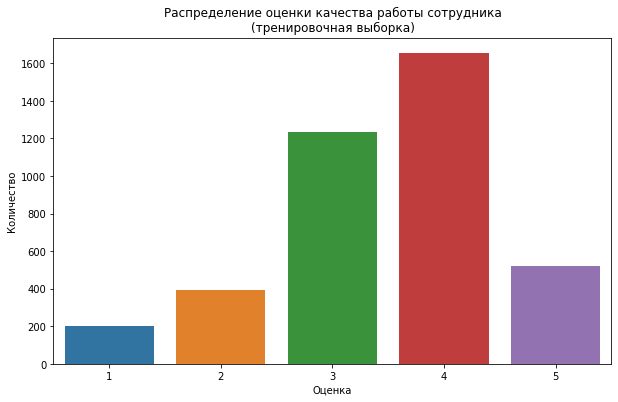

In [81]:
plt.figure(figsize=(10, 6))
barplot = sns.countplot(data=train_quit, x='supervisor_evaluation')
barplot.axes.set_title('Распределение оценки качества работы сотрудника\n(тренировочная выборка)')
barplot.set_xlabel('Оценка')
barplot.set_ylabel('Количество');

Распределение оценки качества работы сотрудника является асимметричным. В основном руководители дают положительную оценку качества работы сотрудника (3-4).

Отобразим гистограмму и "ящик с усами" для столбца `salary`:

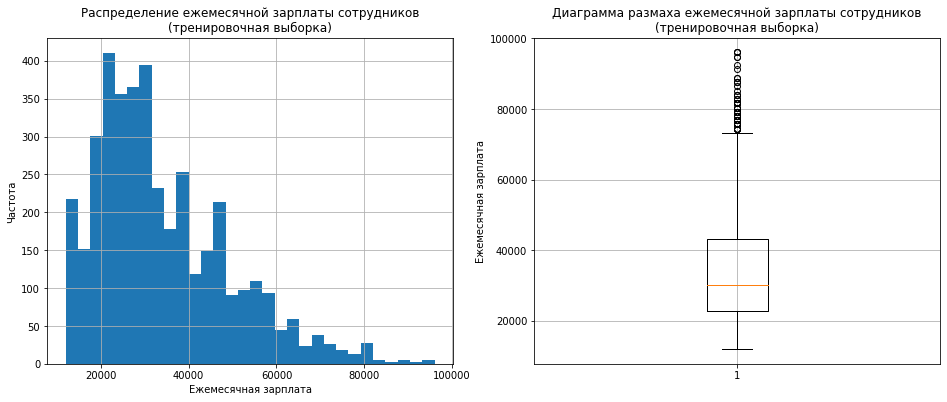

In [82]:
show_graph_1(
    train_quit['salary'],
    'Распределение ежемесячной зарплаты сотрудников\n(тренировочная выборка)',
    'Ежемесячная зарплата',
    'Диаграмма размаха ежемесячной зарплаты сотрудников\n(тренировочная выборка)'
)

Распределение ежемесячной зарплаты сотрудников похоже на распределение Пуассона. Большая часть сотрудников получает зарплату 20000-30000. На графике видна малая часть работников с высокой заработной платой, видимо это руководство компании. Эти данные не считаются аномалиями, поэтому их не будем исключать из анализа.

#### Категориальные признаки

Определим категориальные признаки датафрейма `train_quit` (тренировочная выборка):

In [83]:
get_columns(train_quit)['cat_col_names']

['dept',
 'level',
 'workload',
 'last_year_promo',
 'last_year_violations',
 'quit']

Проведем исследовательский анализ категориальных данных датафрейма `train_quit`.

Отобразим столбчатую и круговую диаграммы для столбца `dept`:

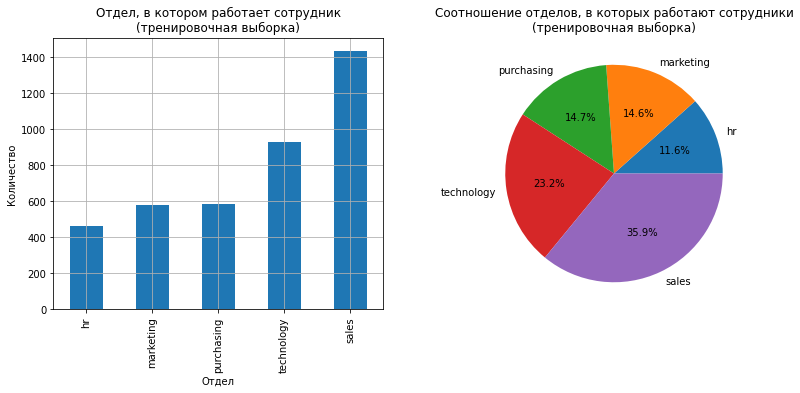

In [84]:
show_graph_2(
    train_quit['dept'],
    'Отдел, в котором работает сотрудник\n(тренировочная выборка)',
    'Отдел',
    'Соотношение отделов, в которых работают сотрудники\n(тренировочная выборка)'
)

Большинство сотрудников работают в продажах (36%), меньше всего работников - в управлении персоналом (12%).

Отобразим столбчатую и круговую диаграммы для столбца `level`:

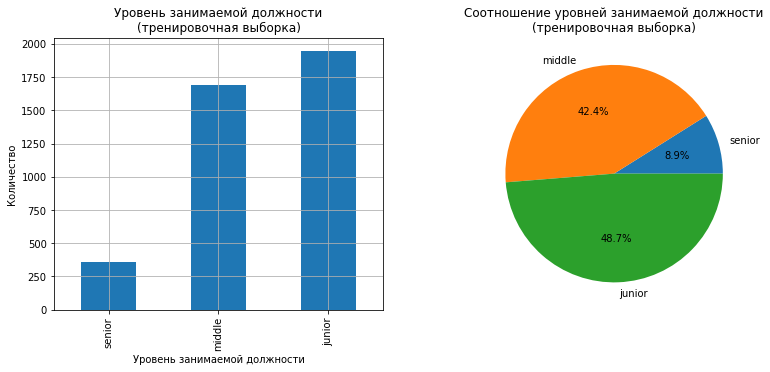

In [85]:
show_graph_2(
    train_quit['level'],
    'Уровень занимаемой должности\n(тренировочная выборка)',
    'Уровень занимаемой должности',
    'Соотношение уровней занимаемой должности\n(тренировочная выборка)'
)

В компании больше всего работников уровней junior (49%) и middle (42%).

Отобразим столбчатую и круговую диаграммы для столбца `workload`:

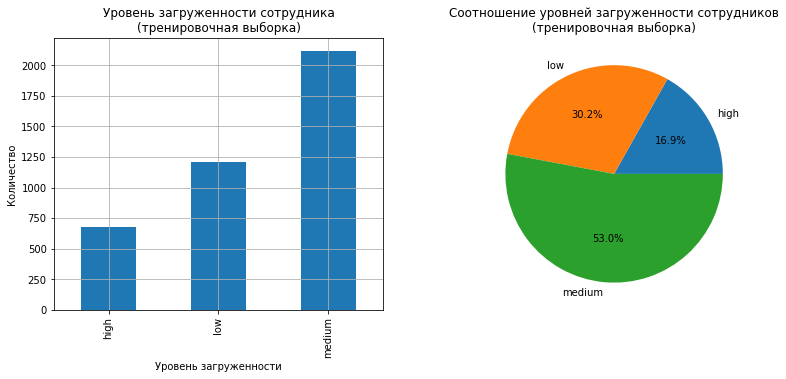

In [86]:
show_graph_2(
    train_quit['workload'],
    'Уровень загруженности сотрудника\n(тренировочная выборка)',
    'Уровень загруженности',
    'Соотношение уровней загруженности сотрудников\n(тренировочная выборка)'
)

53% сотрудников имеют среднюю загрузку, высокую загрузку имеют 17% работников.

Отобразим столбчатую и круговую диаграммы для столбца `last_year_promo`:

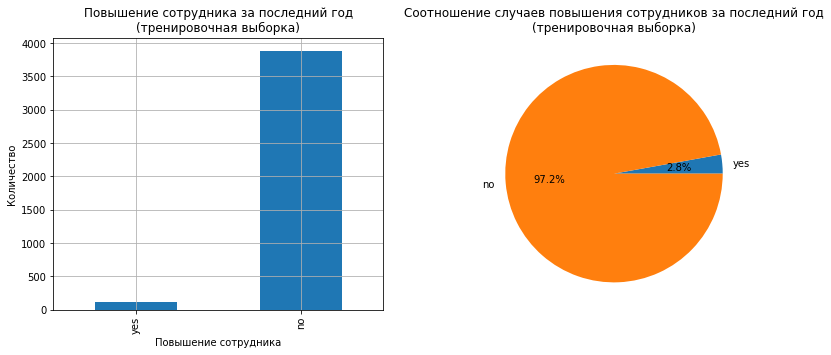

In [87]:
show_graph_2(
    train_quit['last_year_promo'],
    'Повышение сотрудника за последний год\n(тренировочная выборка)',
    'Повышение сотрудника',
    'Соотношение случаев повышения сотрудников за последний год\n(тренировочная выборка)'
)

Подавляющее большинство сотрудников (97%) не имело повышения за последний год.

Отобразим столбчатую и круговую диаграммы для столбца `last_year_violations`:

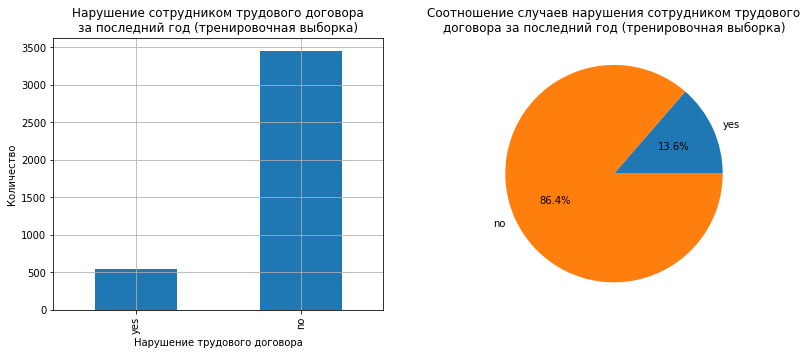

In [88]:
show_graph_2(
    train_quit['last_year_violations'],
    'Нарушение сотрудником трудового договора\nза последний год (тренировочная выборка)',
    'Нарушение трудового договора',
    'Соотношение случаев нарушения сотрудником трудового\nдоговора за последний год (тренировочная выборка)'
)

Подавляющее большинство сотрудников (86%) не нарушало трудовой договор за последний год.

Отобразим столбчатую и круговую диаграммы для столбца `quit`:

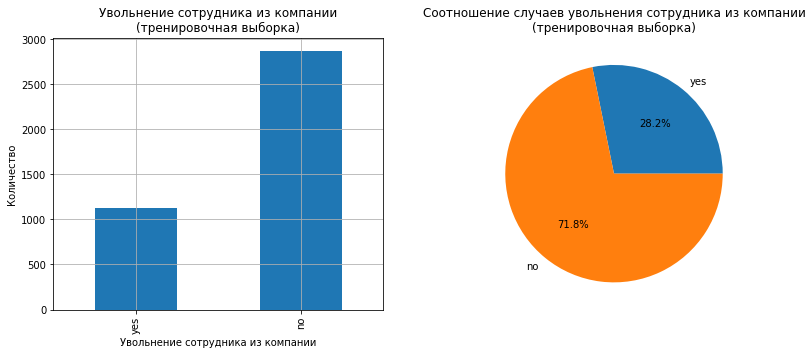

In [89]:
show_graph_2(
    train_quit['quit'],
    'Увольнение сотрудника из компании\n(тренировочная выборка)',
    'Увольнение сотрудника из компании',
    'Соотношение случаев увольнения сотрудника из компании\n(тренировочная выборка)'
)

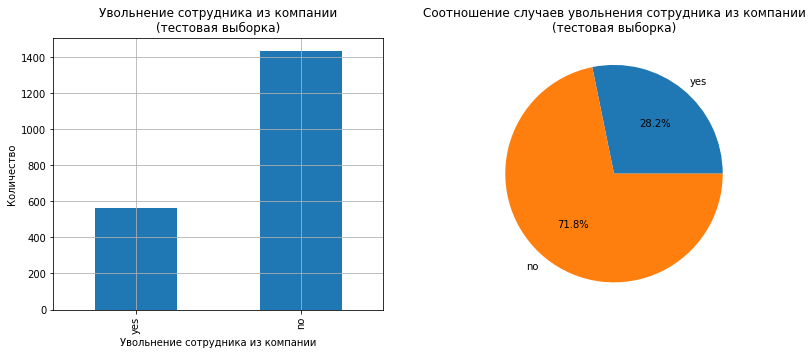

In [90]:
show_graph_2(
    test_target_quit['quit'],
    'Увольнение сотрудника из компании\n(тестовая выборка)',
    'Увольнение сотрудника из компании',
    'Соотношение случаев увольнения сотрудника из компании\n(тестовая выборка)'
)

Число уволившихся сотрудников превышает четверть от всего коллектива (28%).

#### Портрет «уволившегося сотрудника»

На основе данных датафрейма `train_quit` составим портрет "уволившегося сотрудника".

Сформируем таблицы с уволившимися и оставшимися сотрудниками:

In [91]:
quit = train_quit[train_quit['quit'] == 'yes']
no_quit = train_quit[train_quit['quit'] == 'no']

Определим, в каких отделах больше всего уволившихся сотрудников:

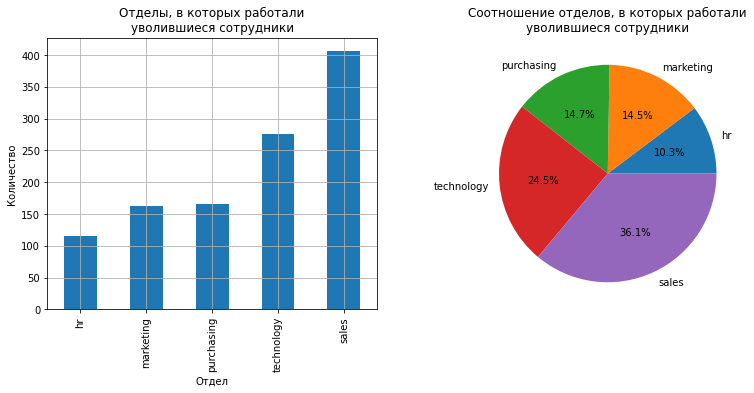

In [92]:
show_graph_2(
    quit['dept'],
    'Отделы, в которых работали\nуволившиеся сотрудники',
    'Отдел',
    'Соотношение отделов, в которых работали\nуволившиеся сотрудники'
)

Больше всего сотрудников увольняется из отдела продаж (36%), в управлении персоналом текучка самая маленькая (10%).

Определим занимаемую должность уволенных сотрудников:

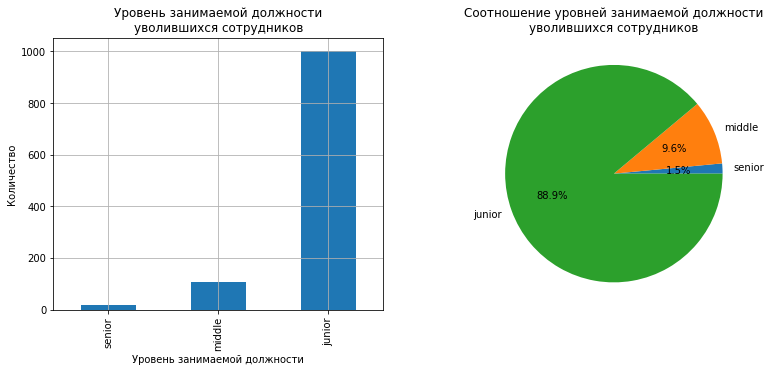

In [93]:
show_graph_2(
    quit['level'],
    'Уровень занимаемой должности\nуволившихся сотрудников',
    'Уровень занимаемой должности',
    'Соотношение уровней занимаемой должности\nуволившихся сотрудников'
)

Преобладающая доля уволенных сотрудников имеет должностной уровень junior (89%).

Проанализируем, как были загружены на работе уволившиеся сотрудники:

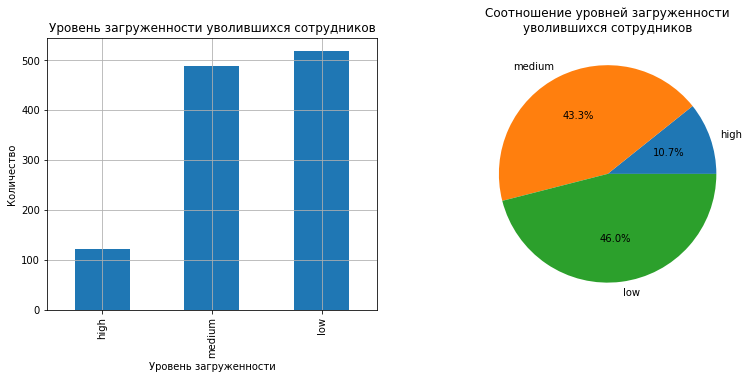

In [94]:
show_graph_2(
    quit['workload'],
    'Уровень загруженности уволившихся сотрудников',
    'Уровень загруженности',
    'Соотношение уровней загруженности\nуволившихся сотрудников'
)

Примерно равные доли (43-46%) имеют уволившиеся сотрудники, которые были загружены на низком и среднем уровне.

Определим, сколько уволившиеся сотрудники работали в компании:

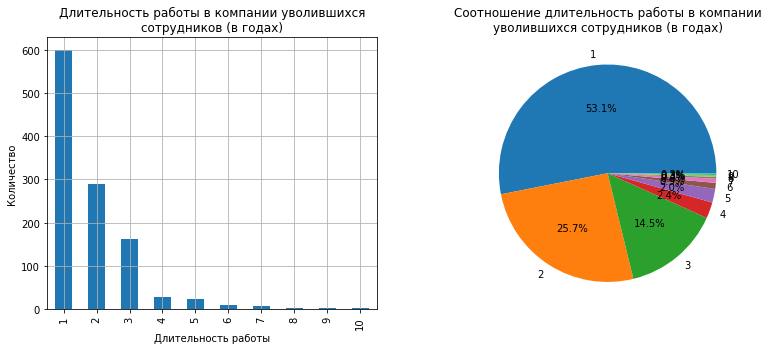

In [95]:
show_graph_2(
    quit['employment_years'],
    'Длительность работы в компании уволившихся\nсотрудников (в годах)',
    'Длительность работы',
    'Соотношение длительность работы в компании\nуволившихся сотрудников (в годах)',
    False
)

Больше половины уволившихся сотрудников (53%) увольняются в течение одного года работы в компании.

Определим долю уволившихся сотрудников, получивших повышение:

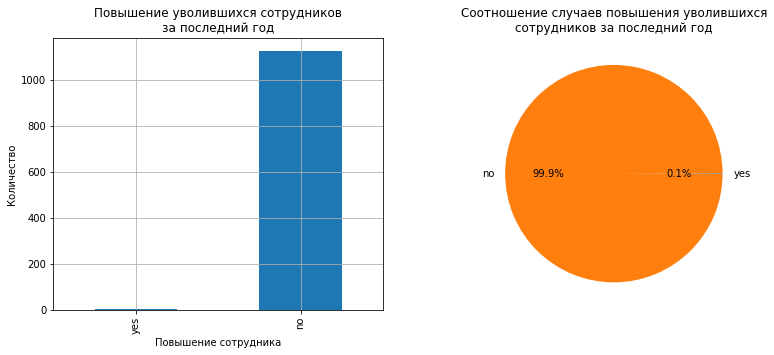

In [96]:
show_graph_2(
    quit['last_year_promo'],
    'Повышение уволившихся сотрудников\nза последний год',
    'Повышение сотрудника',
    'Соотношение случаев повышения уволившихся\nсотрудников за последний год'
)

Практически все уволившиеся сотрудники за последний год не получали повышения.

Найдем долю уволившихся сотрудников, нарушивших за последний год трудовой договор:

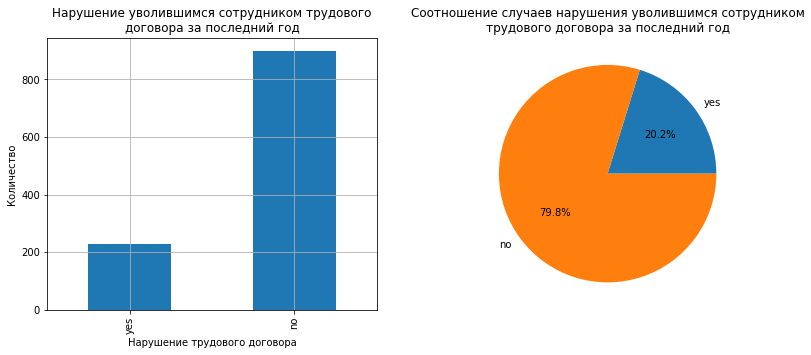

In [97]:
show_graph_2(
    quit['last_year_violations'],
    'Нарушение уволившимся сотрудником трудового\nдоговора за последний год',
    'Нарушение трудового договора',
    'Соотношение случаев нарушения уволившимся сотрудником\nтрудового договора за последний год'
)

Около 80% уволившихся работников не нарушали в последний год трудовой договор.

Посмотрим, как распределены оценки качества работы уволившихся сотрудников:

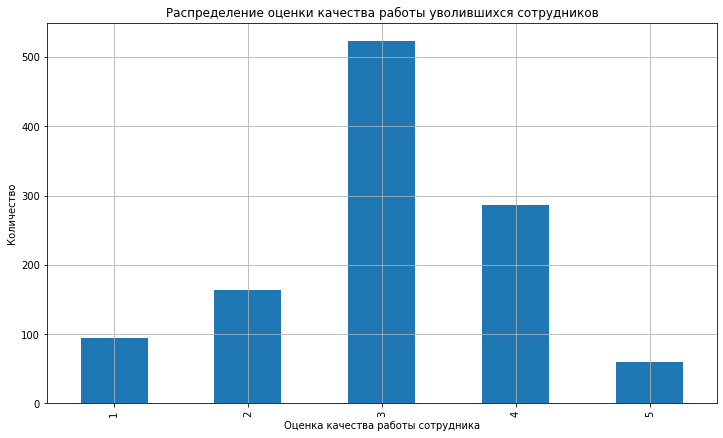

In [98]:
quit.pivot_table(
    index='supervisor_evaluation',
    values='id',
    aggfunc='count'
).plot(
    kind='bar',
    title='Распределение оценки качества работы уволившихся сотрудников',
    xlabel='Оценка качества работы сотрудника',
    ylabel='Количество',
    legend=False,
    figsize=(12, 7),
    grid=True
);

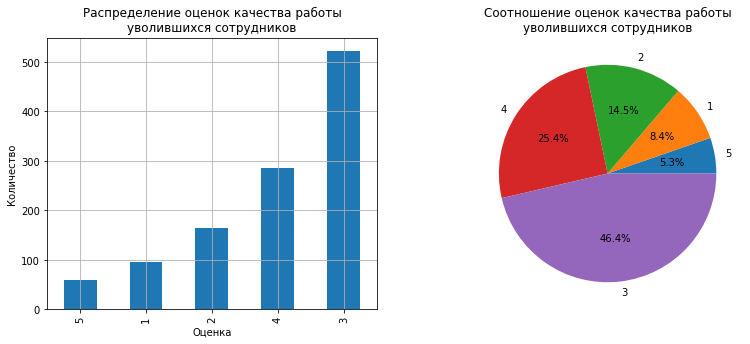

In [99]:
show_graph_2(
    quit['supervisor_evaluation'],
    'Распределение оценок качества работы\nуволившихся сотрудников',
    'Оценка',
    'Соотношение оценок качества работы\nуволившихся сотрудников'
)

Средняя оценка качества работы уволившихся сотрудников составляет 3 балла (46% уволившихся сотрудников).

Оценим распределение ежемесячной зарплаты уволившихся и оставшихся сотрудников:

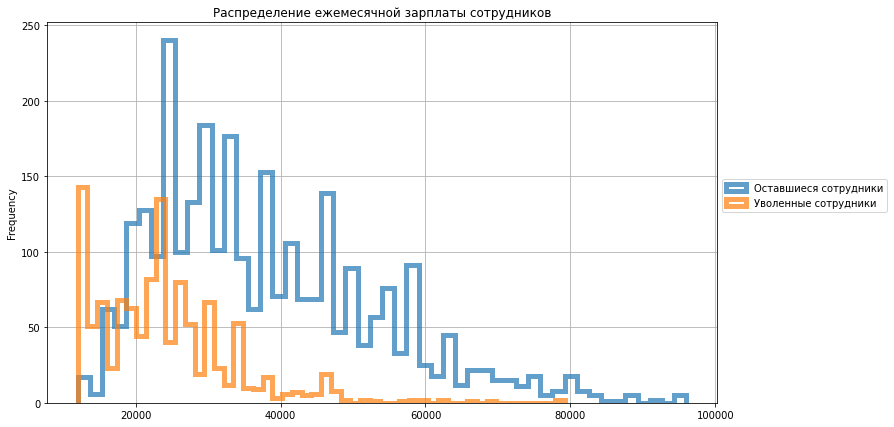

In [100]:
tmp = no_quit.plot(
    kind='hist',
    histtype='step',
    linewidth=5,
    alpha=0.7,
    y='salary',
    bins=50,
    label='Оставшиеся сотрудники',
    grid=True,
    legend=True
)
quit.plot(
    kind='hist',
    ax=tmp,
    histtype='step',
    linewidth=5,
    alpha=0.7,
    y='salary',
    bins=50,
    label='Уволенные сотрудники',
    grid=True,
    legend=True,
    title='Распределение ежемесячной зарплаты сотрудников',
    figsize=(12, 7)
)
plt.legend(bbox_to_anchor=(1, 0.6));

В данном случае мы имеем дело с анализом распределения непрерывной величины, а сам анализ проводится по двум выборкам разного размера - для анализа их распределения стоит использовать нормированную гистограмму (гистограммы такого типа позволяют нивелировать разницу в размерах выборок при анализе распределений). Построим такую гистограмму:

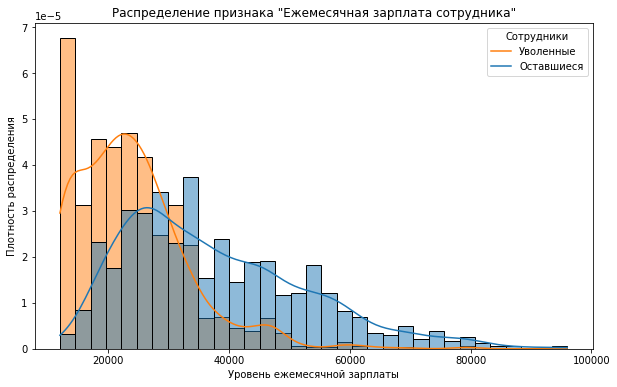

In [131]:
plt.figure(figsize=(10, 6))
histplot = sns.histplot(
    data=train_quit,
    x='salary',
    hue='quit',
    stat='density',
    common_norm=False,
    kde=True
)
histplot.set(
    title='Распределение признака "Ежемесячная зарплата сотрудника"',
    xlabel='Уровень ежемесячной зарплаты',
    ylabel='Плотность распределения'
)
plt.legend(
    title='Сотрудники',
    loc='upper right',
    labels=['Уволенные', 'Оставшиеся']
)
plt.show(histplot)

В распределении ежемесячной зарплаты уволившихся и оставшихся сотрудников видна разница - оставшиеся сотрудники получают зарплату больше тех, кто уволился. Рассчитаем медианные зараплаты двех групп сотрудников:

In [101]:
quit_salary = quit['salary'].median()
no_quit_salary = no_quit['salary'].median()
print('Медианная зарплата уволенных сотрудников:', quit_salary)
print('Медианная зарплата оставшихся сотрудников:', no_quit_salary)
print('Разница зарплат:', no_quit_salary - quit_salary)

Медианная зарплата уволенных сотрудников: 22800.0
Медианная зарплата оставшихся сотрудников: 34800.0
Разница зарплат: 12000.0


Разница в медианной зарплате между двумя группами сотрудников составляет 12000.

Таким образом, портрет "уволившегося сотрудника" следующий:
* С наибольшей долей вероятности работает в отделе продаж
* Имеет должностной уровень junior
* Не имеет высокой загрузки по работе
* В большинстве случаев работает в компании не более двух лет
* За последний год работы не имеет повышений и нарушений трудового договора
* Имеет среднюю оценку качества работы, данную руководителем
* В среднем зарабатывает 23000 (на 12000 меньше, чем оставшися работники)

#### Влияние уровня удовлетворенности работой на увольнение сотрудника

Проверим утверждение аналитиков о том, что уровень удовлетворенности сотрудника работой в компании влияет на то, уволится ли сотрудник. Для этого визуализируем и сравним распределения признака `job_satisfaction_rate` для ушедших и оставшихся сотрудников. Будем использовать данные с обоими целевыми признаками тестовой выборки:

In [102]:
targets = test_target_job_satisfaction_rate.merge(test_target_quit, on='id', how='left')
targets_quit_no = targets[targets['quit'] == 'no']
targets_quit_yes = targets[targets['quit'] == 'yes']

Для каждой группы сотрудников (уволившиеся и оставшиеся) построим распределение признака `job_satisfaction_rate`:

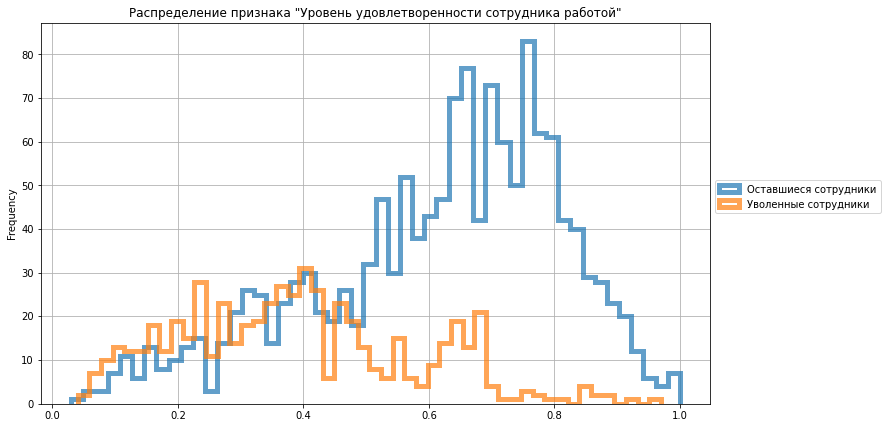

In [103]:
tmp = targets_quit_no.plot(
    kind='hist',
    histtype='step',
    linewidth=5,
    alpha=0.7,
    y='job_satisfaction_rate',
    bins=50,
    label='Оставшиеся сотрудники',
    grid=True,
    legend=True
)
targets_quit_yes.plot(
    kind='hist',
    ax=tmp,
    histtype='step',
    linewidth=5,
    alpha=0.7,
    y='job_satisfaction_rate',
    bins=50,
    label='Уволенные сотрудники',
    grid=True,
    legend=True,
    title='Распределение признака "Уровень удовлетворенности сотрудника работой"',
    figsize=(12, 7)
)
plt.legend(bbox_to_anchor=(1, 0.6));

Уровень удовлетворенности сотрудника работой для оставшихся работников выше, чем для уволенных. Проверим это также, посчитав медианное значение признака:

In [104]:
print('Уровень удовлетворенности работой уволившихся сотрудников:', targets_quit_yes['job_satisfaction_rate'].median())
print('Уровень удовлетворенности работой оставшихся сотрудников:', targets_quit_no['job_satisfaction_rate'].median())

Уровень удовлетворенности работой уволившихся сотрудников: 0.37
Уровень удовлетворенности работой оставшихся сотрудников: 0.66


Уровень удовлетворенности работой оставшихся сотрудников практически в два раза выше, чем у уволенных сотрудников. Таким образом, действительно, уровень удовлетворенности сотрудника работой в компании влияет на то, уволится ли сотрудник или нет.

Стоит заметить, что в данном случае мы имеем дело с анализом распределения непрерывной величины, а сам анализ проводится по двум выборкам разного размера - для анализа их распределения стоит использовать нормированную гистограмму (гистограммы такого типа позволяют нивелировать разницу в размерах выборок при анализе распределений). Построим такую гистограмму:

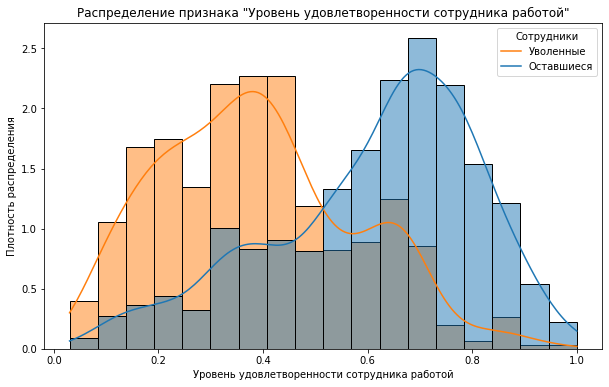

In [105]:
plt.figure(figsize=(10, 6))
histplot = sns.histplot(
    data=targets,
    x='job_satisfaction_rate',
    hue='quit',
    stat='density',
    common_norm=False,
    kde=True
)
histplot.set(
    title='Распределение признака "Уровень удовлетворенности сотрудника работой"',
    xlabel='Уровень удовлетворенности сотрудника работой',
    ylabel='Плотность распределения'
)
plt.legend(
    title='Сотрудники',
    loc='upper right',
    labels=['Уволенные', 'Оставшиеся']
)
plt.show(histplot)

Нормированная гистограмма также подтверждает наши предыдущие выводы - уровень удовлетворенности сотрудника работой для оставшихся работников выше, чем для уволенных.

### Добавление нового входного признака

В предыдущем пункте исследования было доказано, что признаки `job_satisfaction_rate` и `quit` действительно связаны, поэтому добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи:

In [106]:
train_quit['job_satisfaction_rate'] = randomized_search.predict(train_quit.drop(['id', 'quit'], axis=1))
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.607143
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.826111
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.460000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


Аналогичным образом через предсказания новый признак добавим в датафрейм `test_features` (реальные значения мы можем использовать для анализа исторических данных, т.к. они содержат важные паттерны для анализа зависимостей, которые также запоминает и модель, но чтобы иметь возможность работать с новыми работниками без исторических данных, модель должна использовать признак на основе предсказаний):

In [107]:
test_features['job_satisfaction_rate_pred'] = randomized_search.predict(test_features.drop('id', axis=1))
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.853333
1,686555,hr,junior,medium,1,no,no,4,30000,0.681429
2,467458,sales,middle,low,5,no,no,4,19200,0.657143
3,418655,sales,middle,low,6,no,no,4,19200,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.720000


### Корреляционный анализ

Проведем корреляционный анализ признаков в количественной шкале в датафрейме для моделирования `train_quit`. Рассчитаем коэффициенты корреляции между всеми количественными признаками и отобразим матрицу корреляций с помощью тепловой карты:

In [108]:
get_columns(train_quit)['num_col_names']

['id',
 'employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

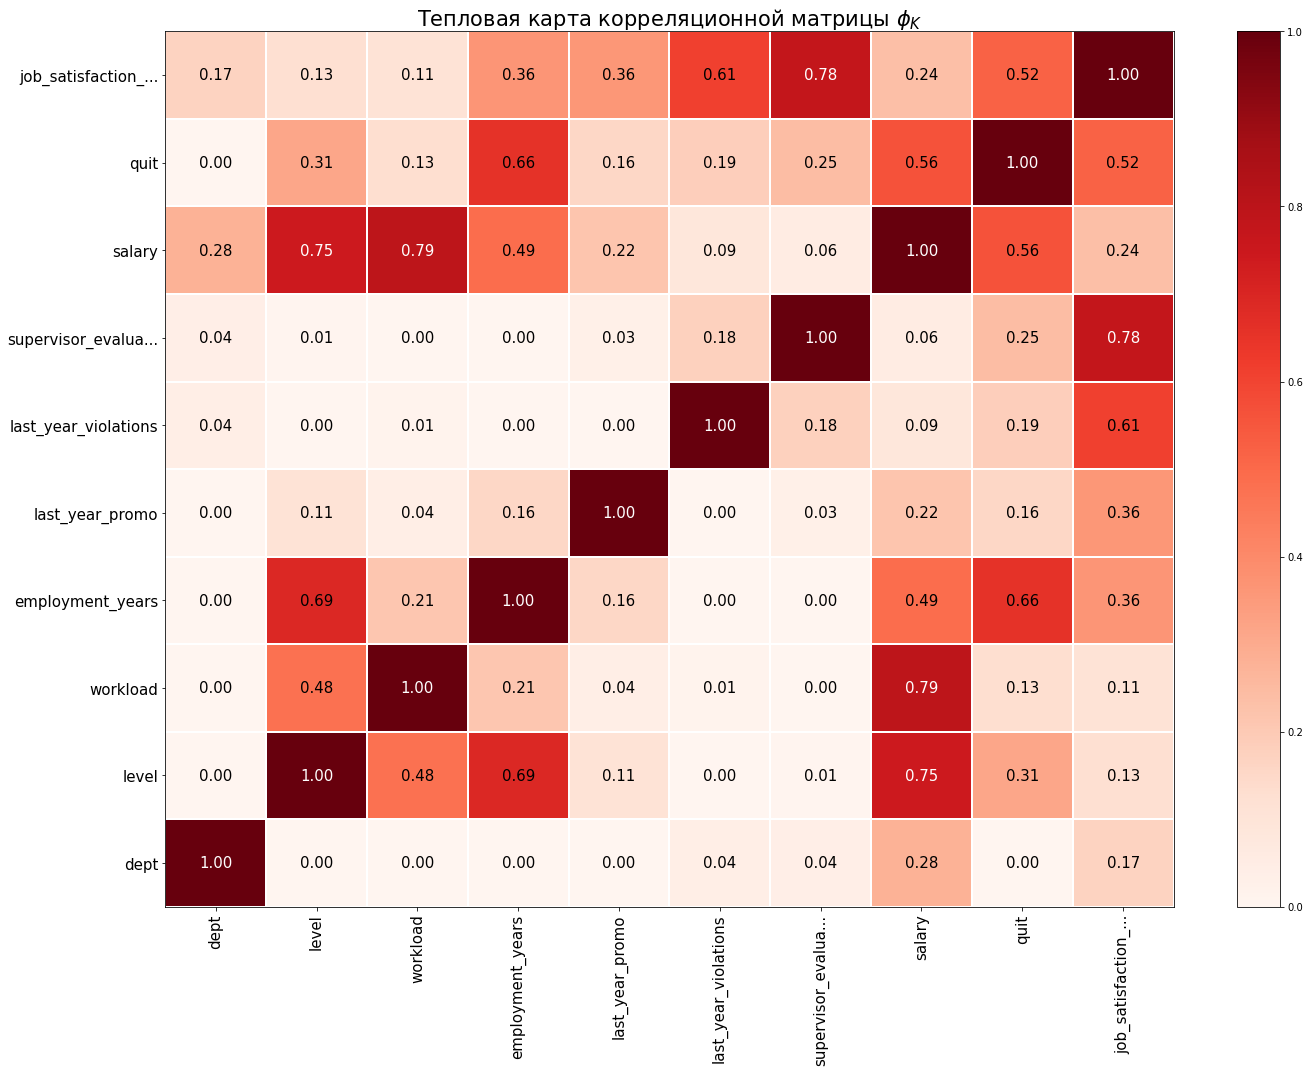

In [109]:
get_cm_plot(train_quit, ['id', 'salary', 'job_satisfaction_rate'])

Судя по тепловой карте, самая сильная прямая связь с целевым признаком `quit` у входных признаков:
* `job_satisfaction_rate` - уровень удовлетворенности работой сильно влияет на то, останется сотрудник в компании или уволится (это мы уже доказали в рамках исследовательского анализа)
* `salary` - уровень ежемесячной зарплаты сотрудника также имеет сильную связь с таргетом: если она не соответствует ожиданиям сотрудников (т.е. ниже их ожиданий), тем более вероятно, что работники увольняются
* `employment_years` - длительность работы в компании влияет на действия сотрудников: чем ниже стаж работы в компании, тем больше вероятность увольнения сотрудника

При этом целевой признак `job_satisfaction_rate` слабо связан с признаком `workload` и совсем не имеет связи с признаком `dept` (уровень загруженности и отдел не влияют на увольнение сотрудника).

Мультиколлинеарность между признаками не обнаружена. От признаков со слабой корреляцией с таргетом избавляться не будем, т.к. они могут быть важны при принятии решения модели. Исключим только признак `dept`, потому что он совсем не связан с целевым признаком.

### Моделирование с использованием пайплайнов

Используя пайплайны, применим следующие модели:
* Модель DecisionTreeClassifier (дерево решений)
* Модель LogisticRegression (логистическая регрессия)
* Модель KNeighborsClassifier (метод k-ближайших соседей)
* Модель SVC (метод опорных векторов)

Константы будем использовать те же, что и в первом разделе исследования.

Разделим данные тренировочной выборки:

In [110]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.607143
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.826111
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.460000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [111]:
label_encoder = LabelEncoder()
X_train_2 = train_quit.drop(['id', 'quit', 'dept'], axis=1)
#y_train_2 = train_quit['quit'].apply(lambda x: 0 if x == 'no' else 1)
y_train_2 = label_encoder.fit_transform(train_quit['quit'])
X_train_2.shape, y_train_2.shape

((4000, 8), (4000,))

Создадим списки с названиями признаков:

In [112]:
ohe_columns_2 = ['last_year_promo', 'last_year_violations']
ord_columns_2 = ['level', 'workload']
num_columns_2 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

Создадим пайплайны для подготовки признаков:

In [113]:
ohe_pipe_2 = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    #('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [114]:
ord_pipe_2 = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'senior'],
            ['low', 'medium', 'high']
        ],
        handle_unknown='use_encoded_value',
        unknown_value=np.nan)
    ),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [115]:
num_pipe_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(2)),
    ('minmax', MinMaxScaler())
])

Создадим общий пайплайн для обработки данных:

In [116]:
data_preprocessor_2 = ColumnTransformer(
    [('ohe', ohe_pipe_2, ohe_columns_2),
     ('ord', ord_pipe_2, ord_columns_2),
     ('num', num_pipe_2, num_columns_2)
    ], 
    remainder='passthrough'
)

Создадим итоговый пайплайн - подготовка данных и модель:

In [117]:
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Создадим словарь со значениями гиперпараметров:

In [118]:
param_grid_2 = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 5),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
        'models__degree': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Как и в первом разделе исследования для поиска лучшей модели будем использовать RandomizedSearchCV:

In [119]:
randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_grid_2, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_2.fit(X_train_2, y_train_2)

print('Лучшая модель и ее параметры:\n\n', randomized_search_2.best_estimator_)
print('Метрика ROC-AUC лучшей модели на кросс-валидации:', randomized_search_2.best_score_)

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                           

На тренировочных данных лучше всех себя показала модель DecisionTreeClassifier со следующими параметрами (значение метрики ROC-AUC на кросс-валидации составило 0.9231):
* max_depth=6
* max_features=4
* min_samples_leaf=2
* min_samples_split=4
* random_state=42

Проверим работу модели на тестовой выборке. Для этого объединим тестовые данные в один датафрейм (чтобы сопоставить данные по каждому пользователю) и посчитаем метрику ROC-AUC на тестовых данных:

In [120]:
test_2 = test_features.merge(test_target_quit, on='id', how='left')#.merge(test_target_job_satisfaction_rate, on='id', how='left')
X_test_2 = test_2.drop(['id', 'quit', 'dept'], axis=1).rename(columns={'job_satisfaction_rate_pred': 'job_satisfaction_rate'})
#y_test_2 = test_2['quit'].apply(lambda x: 0 if x == 'no' else 1)
y_test_2 = label_encoder.transform(test_2['quit'])
X_test_2.shape, y_test_2.shape

((2000, 8), (2000,))

In [121]:
print('Площадь ROC-кривой:', roc_auc_score(y_test_2, randomized_search_2.predict_proba(X_test_2)[:, 1]))

Площадь ROC-кривой: 0.9266147592801122


Критерий успеха - значение метрики ROC-AUC на тестовой выборке не меньше 0.91, получается, что модель работает успешно.

Как и в первом разделе исследования проверим лучшую модель на адекватность, сравнив качество ее предсказаний с качеством модели, которая предсказывала бы константу - в качестве константной модели будем использовать DummyRegressor:

In [122]:
param_grid_dummy_2 = [
    # словарь для модели DummyClassifier()
    {
        'models': [DummyClassifier()],
        'models__strategy': ['most_frequent', 'prior', 'stratified', 'uniform', 'constant'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [132]:
randomized_search_dummy_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_grid_dummy_2, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_dummy_2.fit(X_train_2, y_train_2)

print('Лучшая модель и ее параметры:\n\n', randomized_search_dummy_2.best_estimator_)
print(f'Метрика ROC-AUC лучшей модели на тестовой выборке: {roc_auc_score(y_test_2, randomized_search_dummy_2.predict_proba(X_test_2)[:, 1])}')

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                           

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/conda/lib/python3.

Результат тестирования нашей модели на тестовой выборке оказался лучше, чем результат константной модели - значит, наша модель не является бесполезной.

### Анализ важности признаков

Проведем оценку важности признаков для лучшей модели.

Лучшая модель:

In [124]:
best_model_2 = randomized_search_2.best_estimator_.named_steps['models']

Данные, на которых модель обучалась:

In [125]:
preprocessor_2 = randomized_search_2.best_estimator_['preprocessor']
X_train_preprocessor_2 = preprocessor_2.transform(X_train_2)
features_names_2 = (list(preprocessor_2['ohe'].get_feature_names_out()) +
                  list(preprocessor_2['ord'].get_feature_names_out()) +
                  list(preprocessor_2['num'].get_feature_names_out()))
X_2 = pd.DataFrame(X_train_preprocessor_2, columns=features_names_2)
X_2.head()

,last_year_promo_yes,last_year_violations_yes,level,workload,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
0,0.0,0.0,1.0,2.0,2.0,4.0,54000.0,0.607143
1,0.0,0.0,0.0,1.0,2.0,4.0,27600.0,0.826111
2,0.0,0.0,1.0,1.0,5.0,1.0,37200.0,0.460000
3,0.0,1.0,0.0,1.0,2.0,3.0,24000.0,0.340000
4,0.0,0.0,0.0,1.0,2.0,5.0,25200.0,0.690000


Произведем оценку важности признаков модели DecisionTreeRegressor:

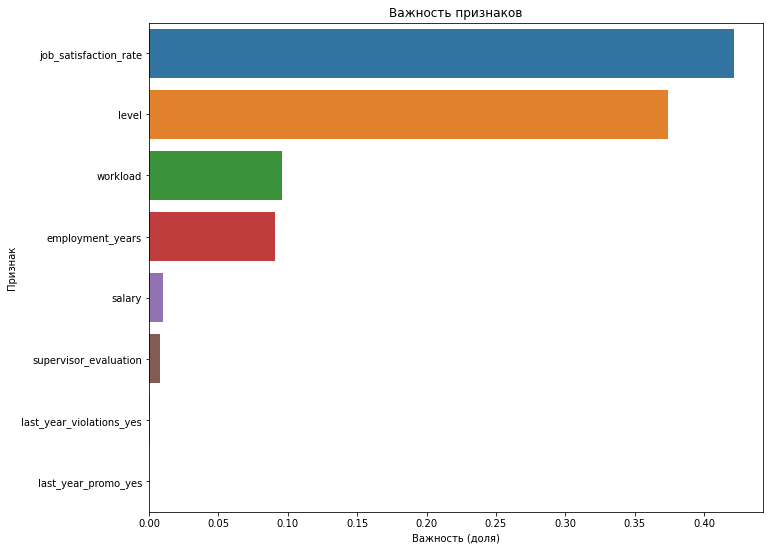

In [126]:
feature_importances_2 = pd.DataFrame({'Признак': X_2.columns, 'Важность': best_model_2.feature_importances_}).sort_values('Важность', ascending=False)
plt.figure(figsize=(11, 9))
ax = sns.barplot(x='Важность', y='Признак', data=feature_importances_2)
ax.set_title('Важность признаков')
ax.set_xlabel('Важность (доля)')
ax.set_ylabel('Признак')
plt.show()

Самыми важными признаками в модели являются:
* `job_satisfaction_rate` - уровень удовлетворенности сотрудника работой в компании имеет наибольшую важность в модели (подтверждение выводов, сделанных на этапе корреляционного анализа)
* `level` - уровень занимаемой должности влияет на увольнение или продолжение работы сотрудником

### Выводы

В данном разделе исследования была найдена и обучена лучшая модель по предсказанию увольнения сотрудника из компании. Оценка качества модели проводилась по метрике ROC-AUC. Значение метрики на тестовой выборке составляет 0.9315, лучшая модель - DecisionTreeClassifier с параметрами:
* max_depth=6
* max_features=4
* min_samples_leaf=2
* min_samples_split=4
* random_state=42

Как и в первом разделе исследования, лучше всего себя показала модель дерева решений, т.к. эти модели лучше объясняют нелинейные зависимости признаков, хорошо справляются с дисбалансом классов, что особенно важно для данной задачи классификации.

Самыми важными признаками в модели являются уровень удовлетворенности сотрудника работой в компании и его уровень занимаемой должности.

## Итоговые выводы

В рамках исследования было необходимо проанализировать данные, предоставленные HR-аналитиками компании «Работа с заботой» с характеристиками сотрудников данной компании. Цель бизнеса - избежать финансовых потерь и оттока сотрудников.

В рамках исследования было необходимо решить несколько задач:
1. Построить модель, которая сможет предсказать уровень удовлетворенности сотрудника на основе данных заказчика
2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Эти задачи являются важнейшими как для HR-аналитиков, так и для бизнеса в целом: удовлетворенность работой напрямую влияет на отток сотрудников, а внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

В ходе исследования при решении данных задач были реализованы следующие этапы:
* Загрузка и предобработка данных (проверка на пропуски и дубликаты данных)
* Исследовательский анализ данных (анализ количественных и категориальных признаков, составление портретв "уволившегося сотрудника", оценка влияния уровня удовлетворенности работой на увольнение сотрудника)
* Корреляционный анализ (оценка взаимосвязи между входными признаками и таргетом, оценка мультиколлинеарности между признаками)
* Подготовка данных и обучение моделей (пайплайны для подготовки данных, перебира моделей по гиперпараметрам)
* Анализ важности признаков для лучшей модели

В качестве лучшей модели для первой и второй задач была получена модель дерево решений. Данная модель показала лучшие результаты метрики на тренировочных данных:
* SMAPE - 14.84 (для первой задачи)
* ROC-AUC - 0.9266 (для второй задачи)

По итогам исследования бизнесу можно дать следующие рекомендации:
* Выявлена зависимость между уровенем удовлетворенности сотрудника работой в компании и увольнением, поэтому полученных моделей и опросов в компании можно предсказывать удовлетворенность сотрудников и при необходимости проводить дополнительные меры для ее увеличения
* Необходимо обратить внимание на отделы, откуда происходит основной отток сотрудников, в частности, отдел продаж
* Т.к. основной поток увольнений происходит от новичков в компании (должностной уровень junior и стаж 1-2 года), то основное внимание стоит уделять данной группе сотрудников: организовывать обучения, тренинги для повышения квалификации, корпоративные мероприятия и т.д. 
* Увольняющиеся сотрудники за последний год работы не имеют повышений, поэтому для ценных кадров необходимо предоставлять гарантии и возможности для карьерного роста
* Пересмотреть уровень заработной платы в сторону увеличения, введения премий за карьерные заслуги и достижения, т.к. сотрудники, уволившиеся из компании получали меньшую зарплату, чем остальные
* Необходимо нагружать сотрудников интересными масштабными задачами, т.к. сотрудник, не имеющий высокой загрузки по работе с большой долей вероятности покинет компанию
* Текучка является неизбежным явлением для бизнеса, поэтому стоит особое внимание уделять ценным, важным, ключевым сотрудникам, приносящим компании пользу